# Vertification of UMM with Tilt

In [66]:
import analysis_utils as au
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import quick_metadata_plots as mplts
import analysis_utils as au
import padeopsIO as pio
import pandas as pd
import seaborn as sns
import streamtube
import itertools

In [67]:
from UnifiedMomentumModel.Momentum import UnifiedMomentum
from UnifiedMomentumModel.Utilities.Geometry import calc_eff_yaw

In [68]:
linewidth = 3.5
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

## UMM Results

### Get UMM Data

In [69]:
n_ct = 3
n_angles = 10
def get_umm_df(n_ct, n_angles):
    n_angles_sqrd = n_angles**2
    ctprimes = [0] * n_angles_sqrd * n_ct
    yaws = [0] * n_angles_sqrd * n_ct
    tilts = [0] * n_angles_sqrd * n_ct
    eff_angles = [0] * n_angles_sqrd * n_ct
    cps = [0] * n_angles_sqrd * n_ct
    ans = [0] * n_angles_sqrd * n_ct
    du4s = [0] * n_angles_sqrd * n_ct
    dv4s = [0] * n_angles_sqrd * n_ct
    dw4s = [0] * n_angles_sqrd * n_ct
    model = UnifiedMomentum()
    yaw_tilt_combos = itertools.product((1, 1.33, 4), np.linspace(0, 30, num = n_angles), np.linspace(0, 30, num = n_angles))
    for (i, (ctp, y, t)) in enumerate(yaw_tilt_combos):
        ctprimes[i] = ctp
        yaws[i] = y
        tilts[i] = t
        y_rad, t_rad = np.deg2rad(y), np.deg2rad(t)
        eff_angles[i] = np.rad2deg(calc_eff_yaw(y_rad, t_rad))
        sol = model(Ctprime = ctp, yaw = y_rad, tilt = t_rad)
        cps[i] = sol.Cp
        ans[i] = sol.an
        du4s[i] = 1 - sol.u4
        dv4s[i] = 0 - sol.v4
        dw4s[i] = 0 - sol.w4

    umm_data = {"Ctprime": ctprimes,
        "yaw": yaws,
        "tilt": tilts,
        "angle": eff_angles,
        "Cp": cps,
        "an": ans,
        "du4": du4s,
        "dv4": dv4s,
        "dw4": dw4s,
        }
    umm_df = pd.DataFrame(umm_data)
    umm_df = umm_df.sort_values(by=['Ctprime', 'angle', 'yaw'], ascending=True)
    return umm_df

In [70]:
umm_df = get_umm_df(n_ct, n_angles)
umm_df

,Ctprime,yaw,tilt,angle,Cp,an,du4,dv4,dw4
0,1.0,0.000000,0.000000,0.000000,0.512127,0.199934,0.391918,0.000000,0.000000
10,1.0,3.333333,0.000000,3.333333,0.510401,0.199479,0.390832,0.009284,0.000000
1,1.0,0.000000,3.333333,3.333333,0.510401,0.199479,0.390832,0.000000,-0.009284
11,1.0,3.333333,3.333333,4.712715,0.508679,0.199025,0.389748,0.009263,-0.009247
2,1.0,0.000000,6.666667,6.666667,0.505236,0.198117,0.387580,0.000000,-0.018411
...,...,...,...,...,...,...,...,...,...
279,4.0,23.333333,30.000000,37.325994,0.457858,0.389412,0.648440,0.093375,-0.108234
297,4.0,30.000000,23.333333,37.325994,0.457858,0.389412,0.648440,0.117875,-0.080866
289,4.0,26.666667,30.000000,39.293816,0.445819,0.378163,0.630926,0.103941,-0.103482
298,4.0,30.000000,26.666667,39.293816,0.445819,0.378163,0.630926,0.115799,-0.090015


In [71]:
limited_tilt_umm_df = umm_df[(umm_df["tilt"] % 10 == 0) & (umm_df["tilt"] <= 30)]
limited_yaw_umm_df = umm_df[(umm_df["yaw"] % 10 == 0) & (umm_df["yaw"] <= 30)]
limited_yaw_tilt_umm_df = limited_tilt_umm_df[(limited_tilt_umm_df["yaw"] % 10 == 0) & (limited_tilt_umm_df["yaw"] <= 30)]

### Plot UMM Data

#### By Yaw and Colored by Tilt

In [90]:
def cp_an_plots(limited_tilt_umm_df):
    an_cp_fig, (an_cp_ax0, an_cp_ax1) = plt.subplots(1, 2, sharey = False, figsize = (8, 4), dpi = 300)
    an_cp_fig.suptitle("Mean $C_p$ vs Yaw ($\gamma$) by Tilt ($\phi$):", size = 16, y = 1.02)

    an_cp_ax0.set_title("C_T' = 1", size = 14)
    an_cp_ax0.set_ylabel('$C_P$', size = 14)
    an_cp_ax0.set_xlabel(' ')
    an_cp_ax0.tick_params(axis='both', which='major', labelsize=12)
    an_cp_ax0.set_ylim(0, 1)

    an_cp_ax1.set_title("C_T' = 4", size = 14)
    an_cp_ax1.set_ylabel(' ')
    an_cp_ax1.set_xlabel(' ')
    an_cp_ax1.tick_params(axis='both', which='major', labelsize=12)
    an_cp_ax1.set_ylim(0, 1)

    sns.lineplot(ax = an_cp_ax0, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == 1],  x = "yaw", y = "Cp", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette)
    sns.lineplot(ax = an_cp_ax1, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == 4],  x = "yaw", y = "Cp", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = False)

    leg = an_cp_ax0.legend(title='Tilt ($\phi$)')
    bb = leg.get_bbox_to_anchor().transformed(an_cp_ax0.transAxes.inverted())
    xOffset = 1.6
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg = leg.set_bbox_to_anchor(bb, transform = an_cp_ax0.transAxes)

    return an_cp_fig, (an_cp_ax0, an_cp_ax1)

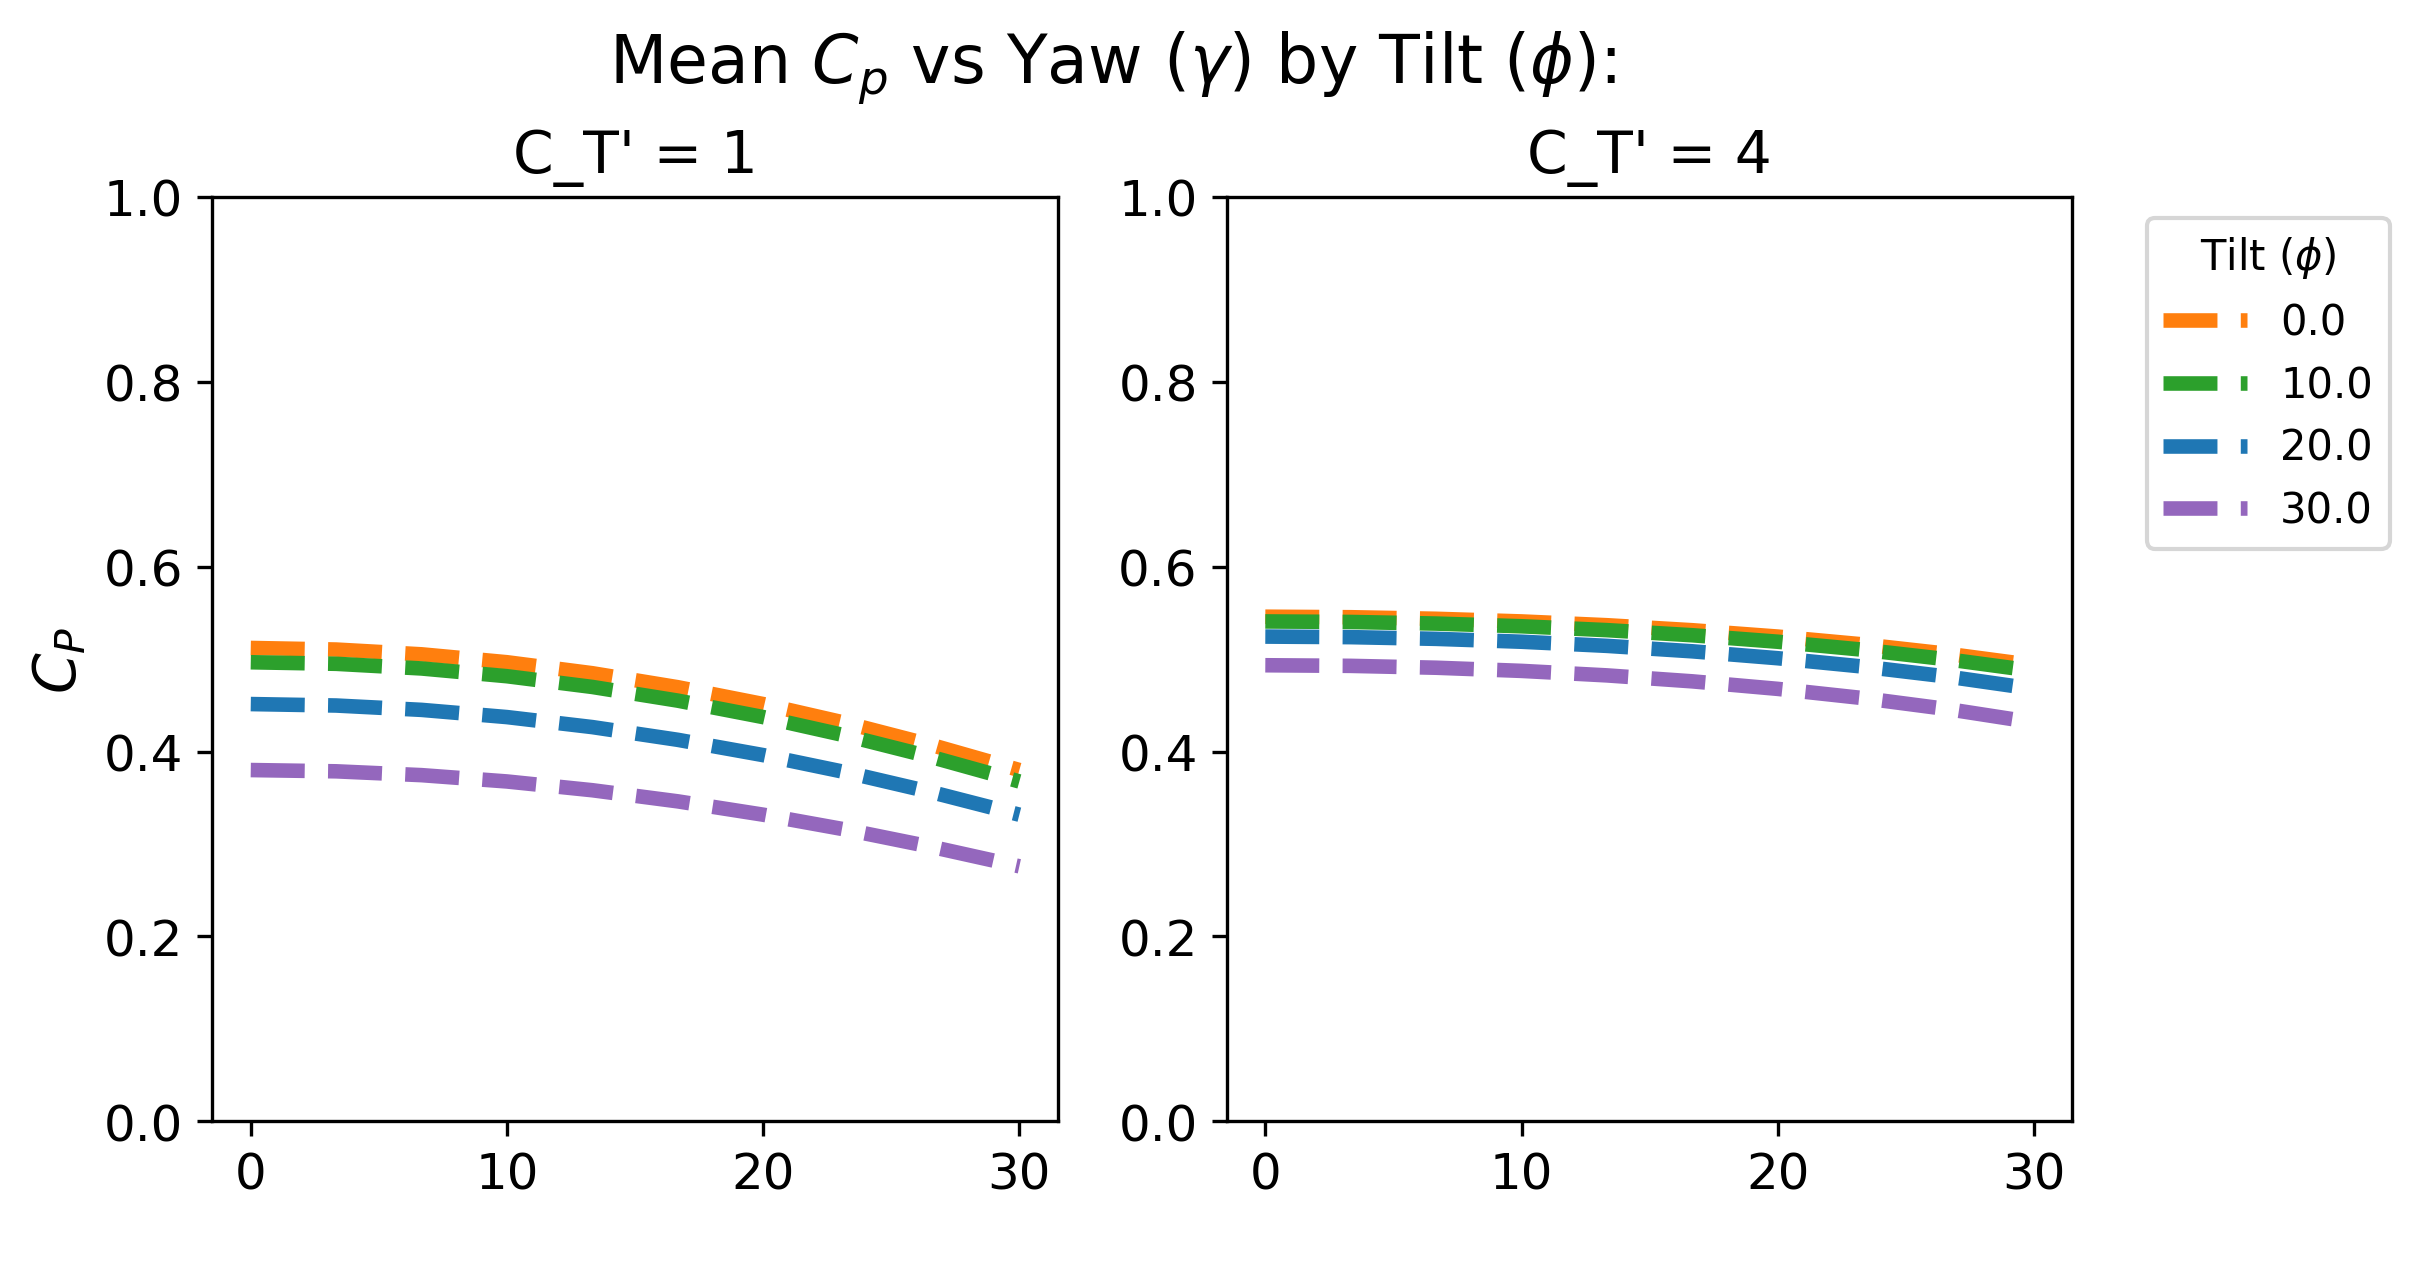

In [91]:
an_cp_fig, (an_cp_ax0, an_cp_ax1) = cp_an_plots(limited_tilt_umm_df)

In [74]:
def plot_vels(limited_tilt_umm_df, limited_yaw_umm_df, ctprime = 1):
    vels_fig0, vels_ax0 = plt.subplots(dpi = 300)
    vels_ax0.set_title(f"$\delta u_4$ vs Yaw ($\gamma$) by Tilt ($\phi$) for $C_T' = {ctprime}$", size = 16)
    vels_ax0.set_ylabel('$\\delta u_4$', size = 16)
    vels_ax0.set_xlabel('Yaw ($\\gamma$)', size = 16)
    vels_ax0.tick_params(axis='both', which='major', labelsize=12)
    sns.lineplot(ax = vels_ax0, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctprime],  x = "yaw", y = "du4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette)
    vels_ax0.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)

    vels_fig1, vels_ax1 = plt.subplots(dpi = 300)
    vels_ax1.set_title(f"$\delta v_4$ vs Yaw ($\gamma$) by Tilt ($\phi$) for $C_T' = {ctprime}$", size = 16)
    vels_ax1.set_ylabel('$\\delta v_4$', size = 16)
    vels_ax1.set_xlabel('Yaw ($\\gamma$)', size = 16)
    vels_ax1.tick_params(axis='both', which='major', labelsize=12)
    sns.lineplot(ax = vels_ax1, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctprime],  x = "yaw", y = "dv4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette)
    vels_ax1.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)

    vels_fig2, vels_ax2 = plt.subplots(dpi = 300)
    vels_ax2.set_title(f"$\delta w_4$ vs Yaw ($\gamma$) by Tilt ($\phi$) for $C_T' = {ctprime}$", size = 16)
    vels_ax2.set_ylabel('$\\delta w_4$', size = 16)
    vels_ax2.set_xlabel('Yaw ($\\gamma$)', size = 16)
    vels_ax2.tick_params(axis='both', which='major', labelsize=12)
    sns.lineplot(ax = vels_ax2, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctprime],  x = "yaw", y = "dw4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette)
    vels_ax2.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)

    return (vels_fig0, vels_ax0), (vels_fig1, vels_ax1), (vels_fig2, vels_ax2)


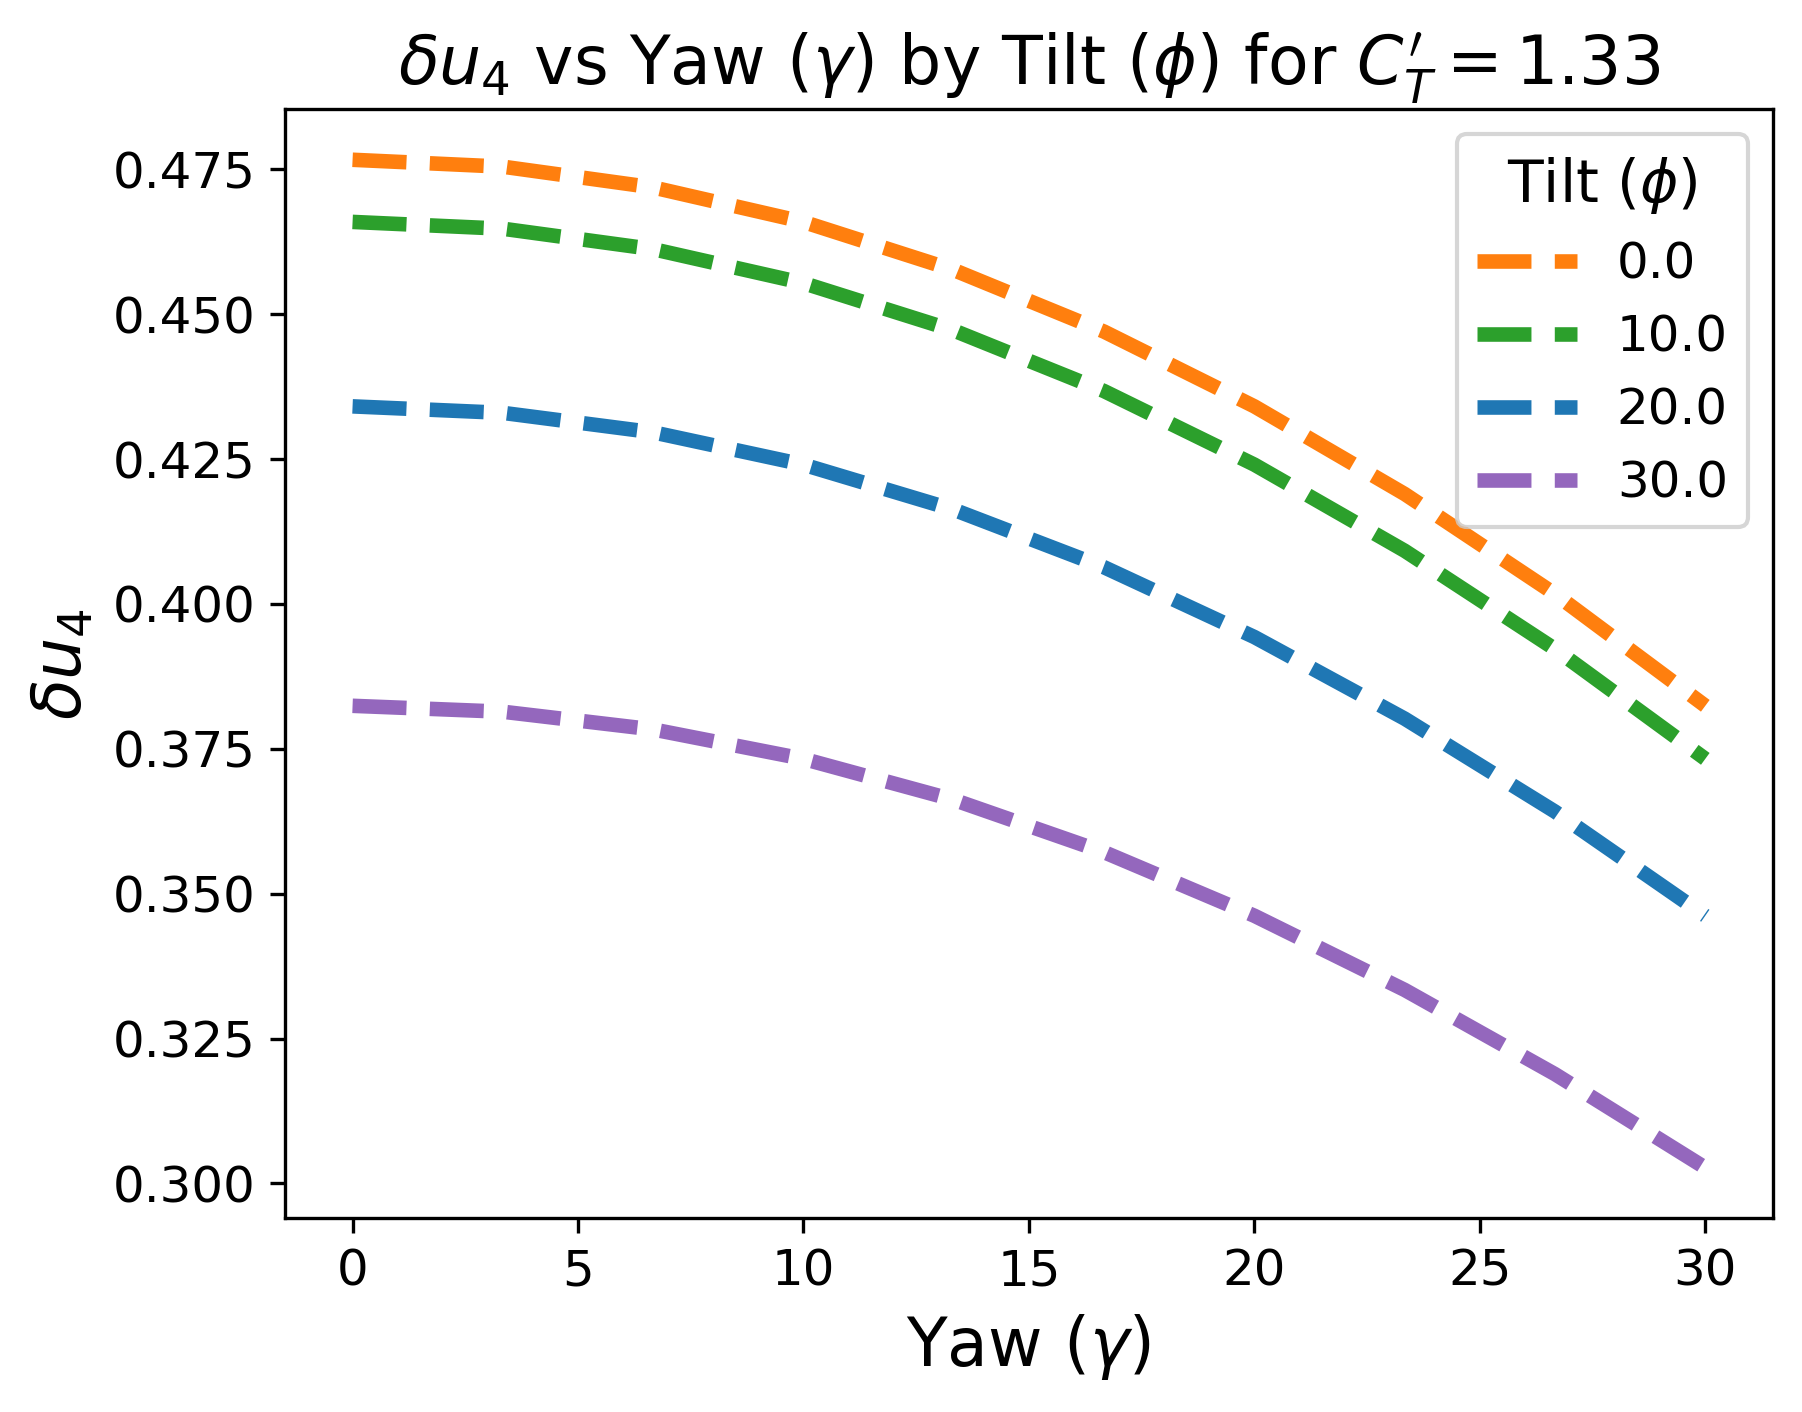

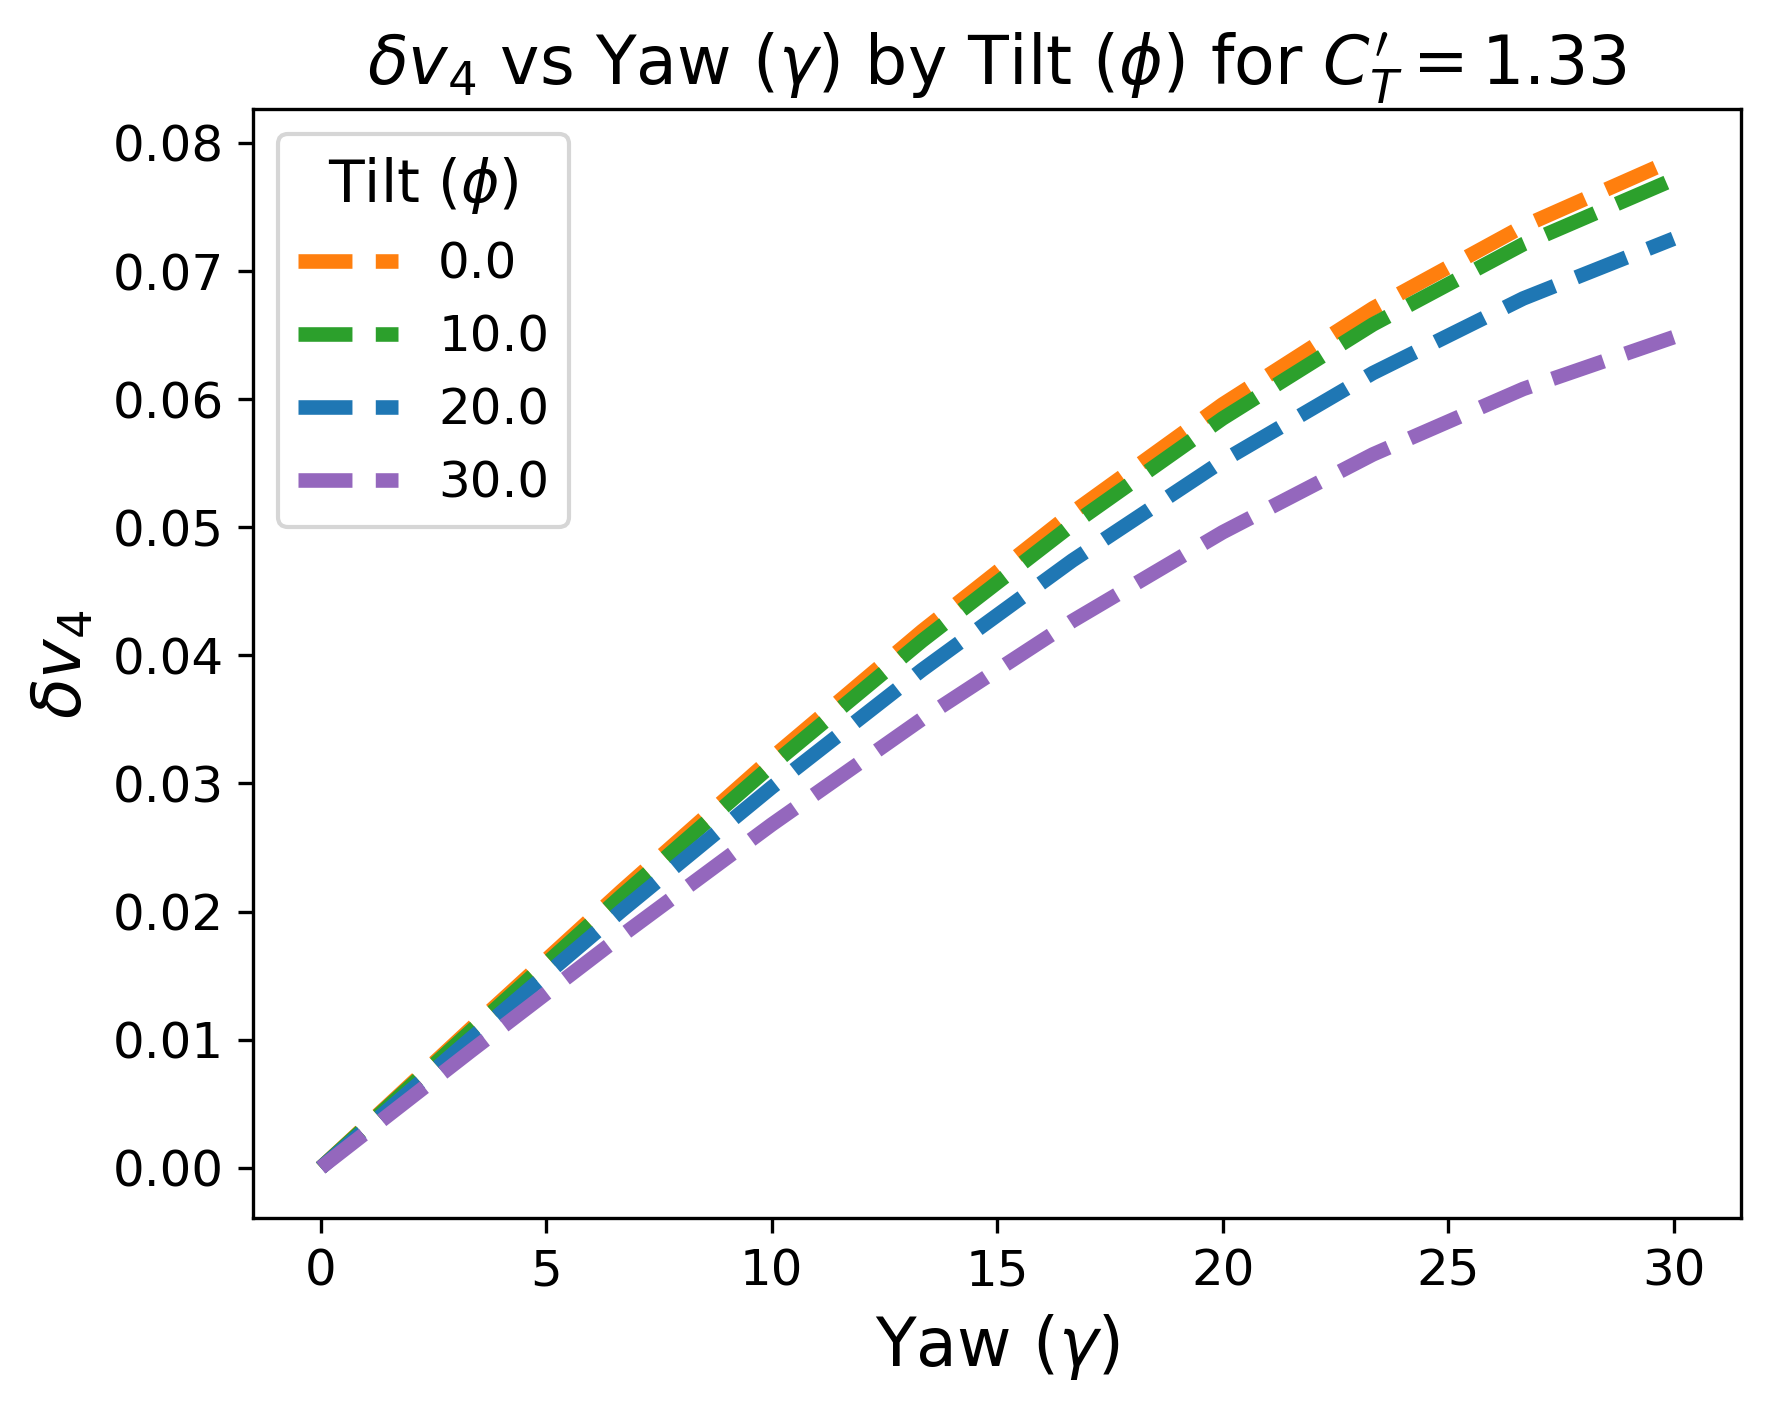

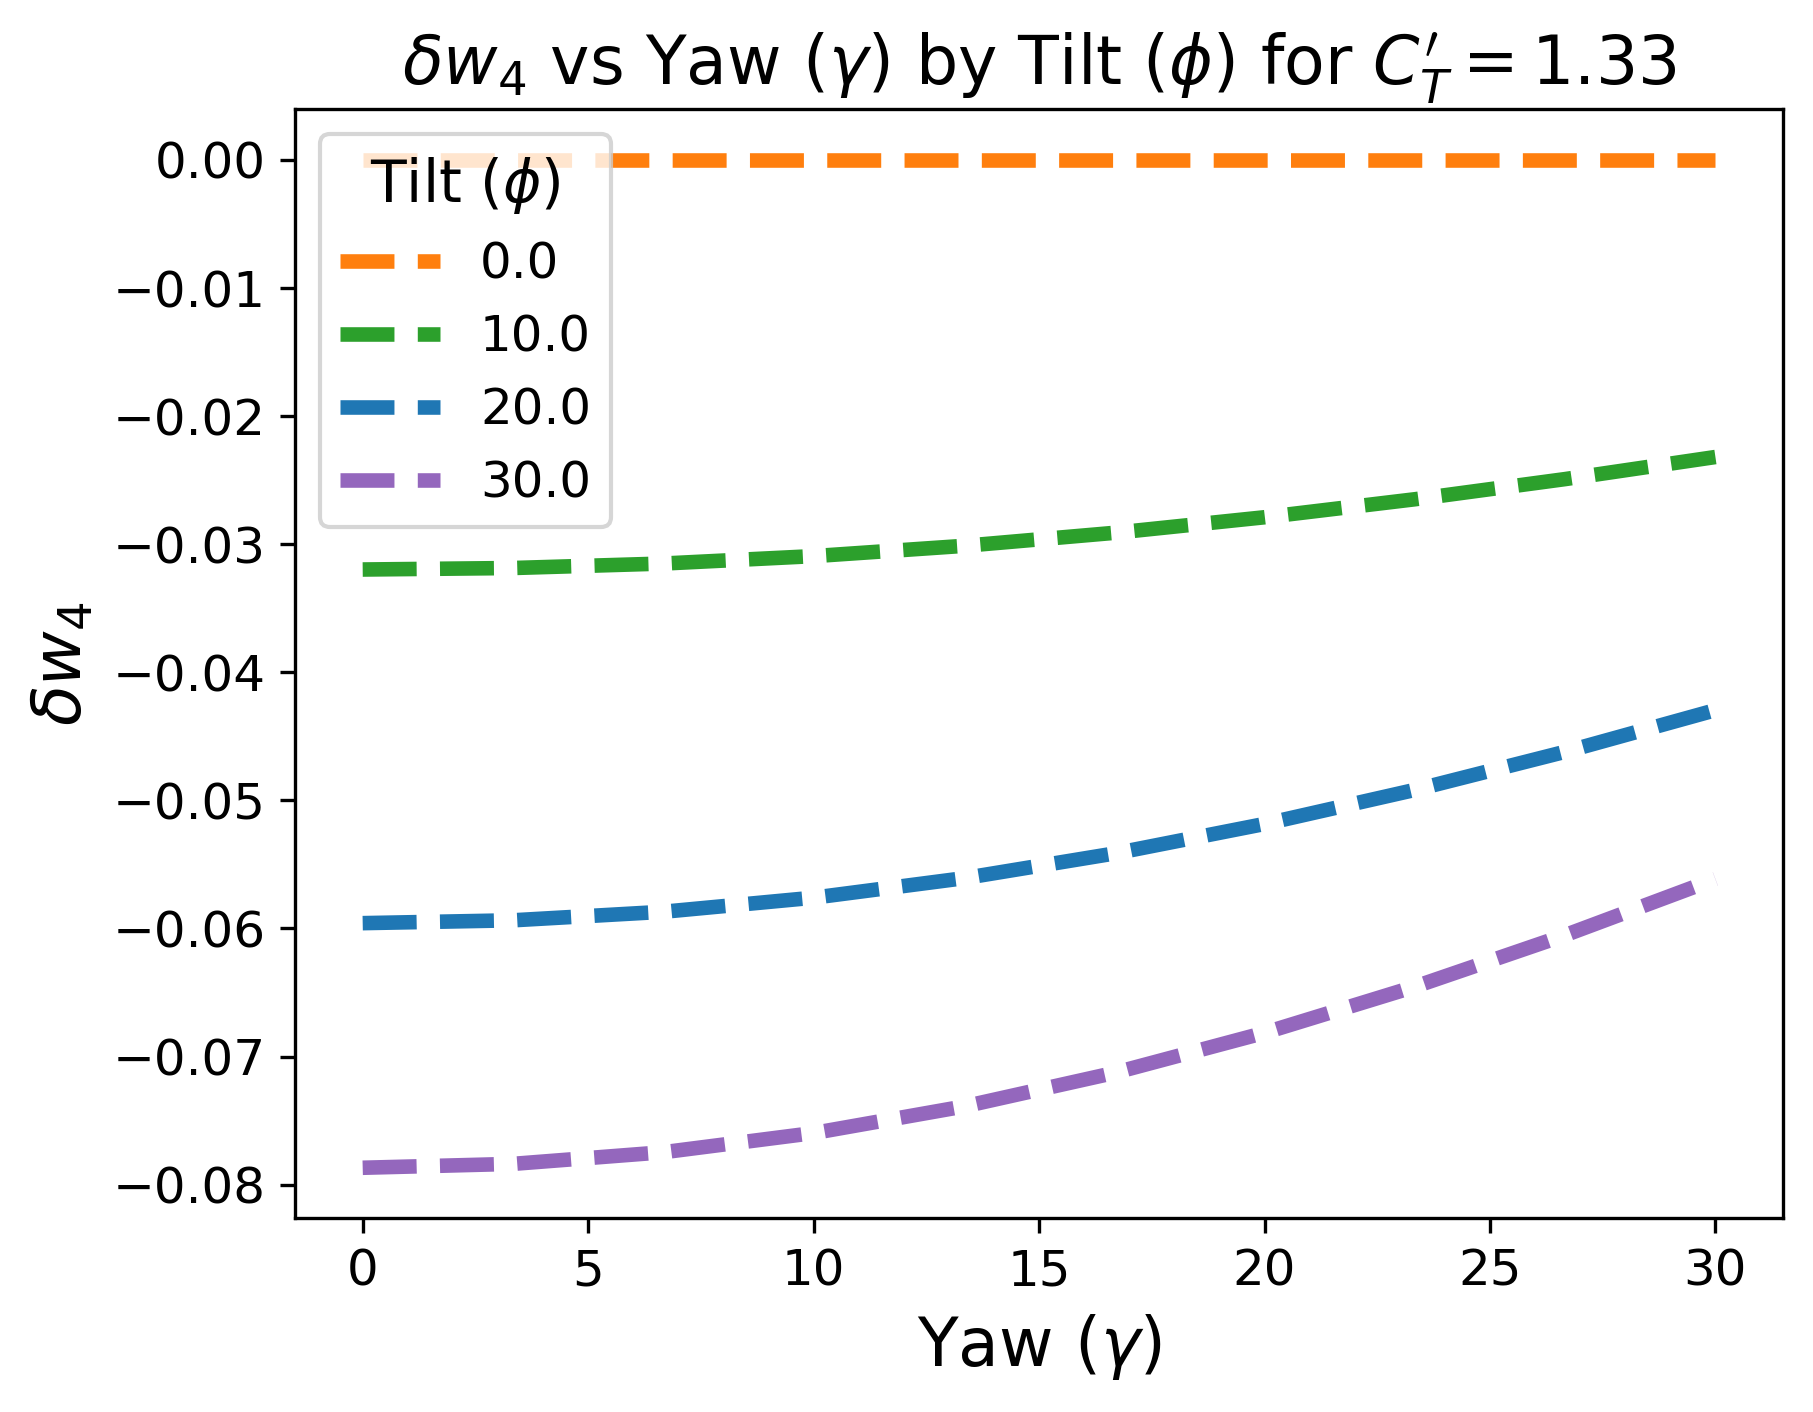

In [75]:
(vels_fig0, vels_ax0), (vels_fig1, vels_ax1), (vels_fig2, vels_ax2) = plot_vels(limited_tilt_umm_df, limited_yaw_umm_df, ctprime = 1.33)

## Get LES PadéOps Data

In [76]:
data_path = Path(au.DATA_PATH)
sim_folder = os.path.join(au.DATA_PATH, "B_0001_Files")
rows, fields = mplts.get_sim_varied_params(sim_folder)
les_ids, les_cT, les_yaw, les_tilt, les_filterWidth = zip(*rows)

In [77]:
def get_wake_vels(sim, filterwidth):
    ds = sim.slice(field_terms=["u", "v", "w", "x", "y", "z"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
    stream = streamtube.Streamtube(ds.x, ds.y, ds.z, ds.u, ds.v, ds.w)
    stream.compute_streamtube(R = 0.5 - filterwidth)  # D/2 - filterwidth
    stream.compute_mask(R = 0.5 - filterwidth)
    dumax, dvmax, dwmax = 0, 0, 0
    for i in range(stream.mask.shape[0]):
        mask = stream.mask[i, :, :]
        umean = np.average(ds.u[i, :, :], weights = mask)
        vmean = np.average(ds.v[i, :, :], weights = mask)
        wmean = np.average(ds.w[i, :, :], weights = mask)
        dumax = (1 - umean) if np.abs(1 - umean) > np.abs(dumax) else dumax
        dvmax = (0 - vmean) if np.abs(0 - vmean) > np.abs(dvmax) else dvmax
        dwmax = (0 - wmean) if np.abs(0 - wmean) > np.abs(dwmax) else dwmax
    return dumax, dvmax, dwmax

In [78]:
def get_les_df(CT_vals, yaw_vals, tilt_vals, filterwidth_vals):
    nruns = len(yaw_vals)
    ctprimes = [0] * nruns
    yaws = [0] * nruns
    tilts = [0] * nruns
    eff_angles = [0] * nruns
    cps = [0] * nruns
    du4s = [0] * nruns
    dv4s = [0] * nruns
    dw4s = [0] * nruns

    for i in range(0, nruns):

        run_folder = au.get_run_folder(sim_folder, i)
        sim = pio.BudgetIO(run_folder, padeops = True, runid = 0, normalize_origin="turbine")

        ctprimes[i] = float(CT_vals[i])
        yaws[i] = float(yaw_vals[i])
        tilts[i] = float(tilt_vals[i])
        y_rad, t_rad = np.deg2rad(yaws[i]), np.deg2rad(tilts[i])
        eff_angles[i] = np.rad2deg(calc_eff_yaw(y_rad, t_rad))

        mean_dt = sim.get_dt()
        power = sim.read_turb_power("all", turb=1)[round(100 / mean_dt):]
        avg_power = np.mean(power)
        cps[i] = au.power_to_Cp(avg_power)

        dumax, dvmax, dwmax = get_wake_vels(sim, float(filterwidth_vals[i]))
        du4s[i], dv4s[i], dw4s[i] = dumax, dvmax, dwmax


    les_data = {"Ctprime": ctprimes,
        "yaw": yaws,
        "tilt": tilts,
        "angle": eff_angles,
        "Cp": cps,
        "du4": du4s,
        "dv4": dv4s,
        "dw4": dw4s,
        }
    les_df = pd.DataFrame(les_data)
    les_df = les_df.sort_values(by=['Ctprime', 'angle', 'yaw'], ascending=True)
    return les_df

In [79]:
les_df = get_les_df(les_cT, les_yaw, les_tilt, les_filterWidth)
les_df

/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0000 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3758, time: 250.047130


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0001 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3771, time: 250.019092


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0002 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3974, time: 250.058463


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0003 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3972, time: 250.032357


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0004 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3775, time: 250.012316


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0005 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3941, time: 250.048204


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0006 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4031, time: 250.000897


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0007 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4115, time: 250.002036


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0008 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3915, time: 250.004064


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0009 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4049, time: 250.022180


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0010 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4206, time: 250.052265


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0011 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4153, time: 250.026497


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0012 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3948, time: 250.034384


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0013 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4076, time: 250.030931


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0014 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4039, time: 250.027319


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0015 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4006, time: 250.052655


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0016 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5062, time: 250.017421


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0017 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5235, time: 250.046442


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0018 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5334, time: 250.008880


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0019 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5280, time: 250.014392


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0020 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5250, time: 250.046490


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0021 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5338, time: 250.016198


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0022 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5392, time: 250.006770


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0023 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5342, time: 250.044447


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0024 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5160, time: 250.019376


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0025 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5244, time: 250.032070


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0026 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5559, time: 250.044329


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0027 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5200, time: 250.042772


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0028 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5254, time: 250.033654


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0029 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5401, time: 250.040904


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0030 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5207, time: 250.022989


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0031 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5073, time: 250.038724


,Ctprime,yaw,tilt,angle,Cp,du4,dv4,dw4
0,1.0,0.0,0.0,0.000000,0.518540,0.396347,-4.061089e-09,4.389986e-10
4,1.0,10.0,0.0,10.000000,0.500954,0.384266,2.670630e-02,-2.470699e-11
1,1.0,0.0,10.0,10.000000,0.501013,0.384233,-7.407047e-10,-2.654256e-02
5,1.0,10.0,10.0,14.106044,0.483823,0.372174,2.629367e-02,-2.570988e-02
2,1.0,0.0,20.0,20.000000,0.449799,0.350222,-2.626164e-08,-5.027967e-02
8,1.0,20.0,0.0,20.000000,0.449591,0.351856,5.072480e-02,-9.897971e-11
6,1.0,10.0,20.0,22.268744,0.433862,0.339916,2.525299e-02,-4.882698e-02
9,1.0,20.0,10.0,22.268744,0.433721,0.340065,5.007667e-02,-2.342775e-02
10,1.0,20.0,20.0,27.990891,0.387761,0.310741,4.791808e-02,-4.447800e-02
3,1.0,0.0,30.0,30.000000,0.370121,0.302068,-3.578056e-10,-6.863863e-02


### Plot LES Data

<Axes: title={'center': "C_T' = 4"}, xlabel=' ', ylabel=' '>

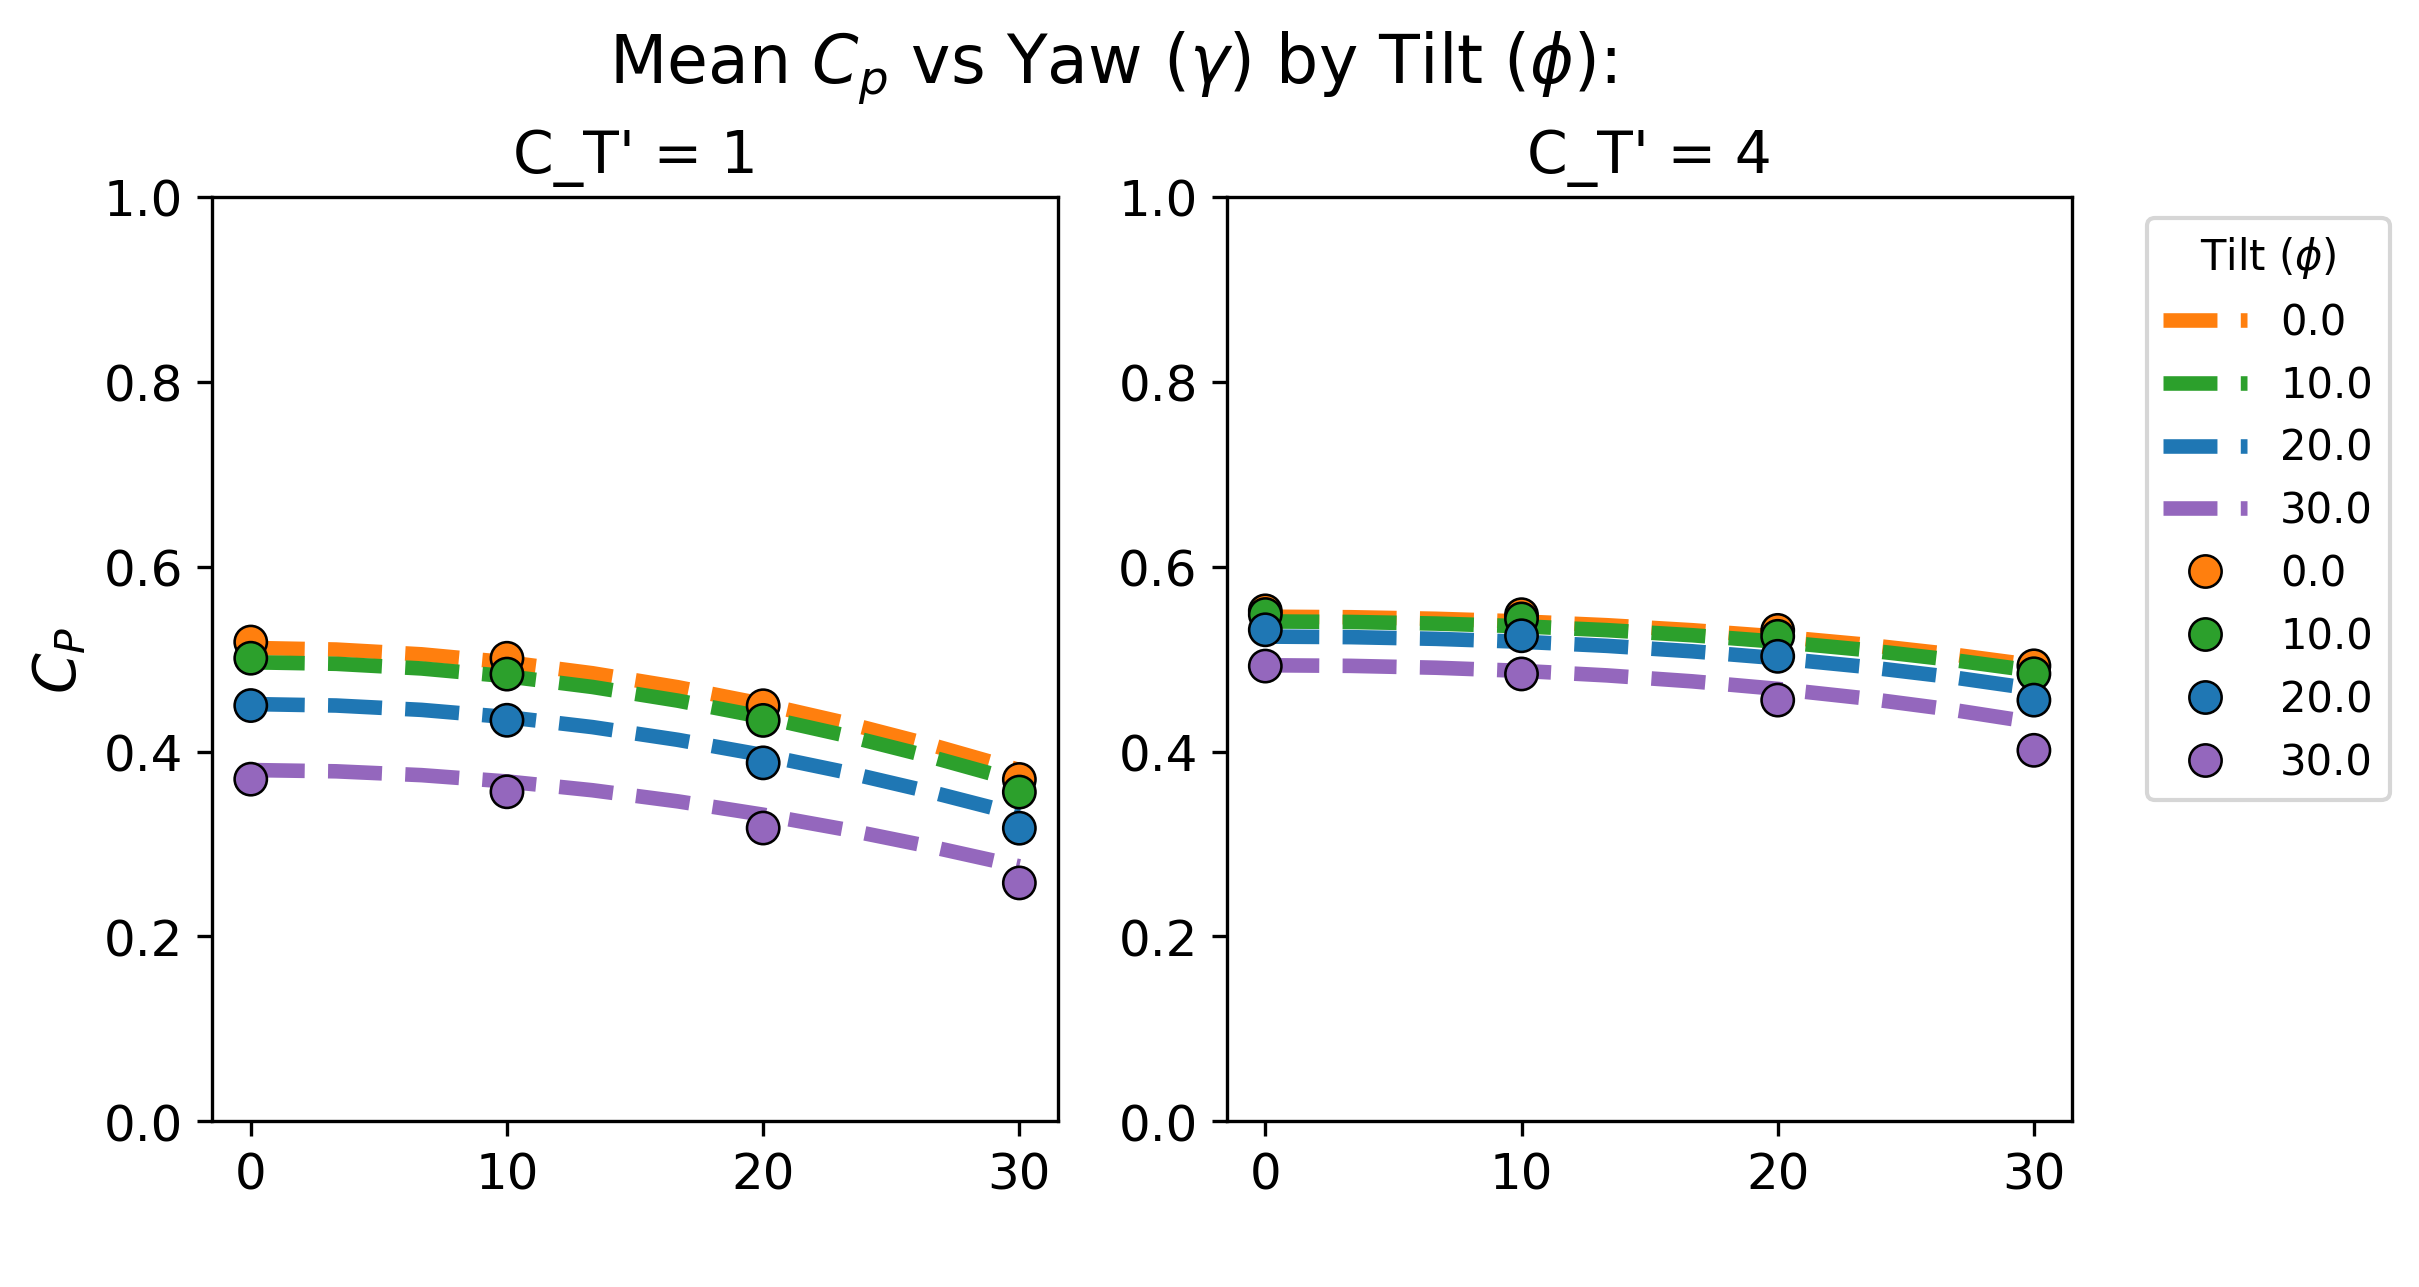

In [92]:
an_cp_fig, (an_cp_ax0, an_cp_ax1) = cp_an_plots(limited_tilt_umm_df)

sns.scatterplot(ax = an_cp_ax0, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "Cp", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5)

leg = an_cp_ax0.legend(title='Tilt ($\phi$)')
bb = leg.get_bbox_to_anchor().transformed(an_cp_ax0.transAxes.inverted())
xOffset = 1.6
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = an_cp_ax0.transAxes)

sns.scatterplot(ax = an_cp_ax1, data = les_df[les_df["Ctprime"] == 4],  x = "yaw", y = "Cp", hue = "tilt", palette = palette, s = 60, edgecolors = "k", legend = False,  zorder = 5)
# sns.scatterplot(ax = an_cp_ax2, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "an", hue = "tilt", palette = palette, s = 60, edgecolors = "k",legend = False)
# sns.scatterplot(ax = an_cp_ax3, data = les_df[les_df["Ctprime"] == 4],  x = "yaw", y = "an", hue = "tilt", palette = palette, s = 60, edgecolors = "k",legend = False)

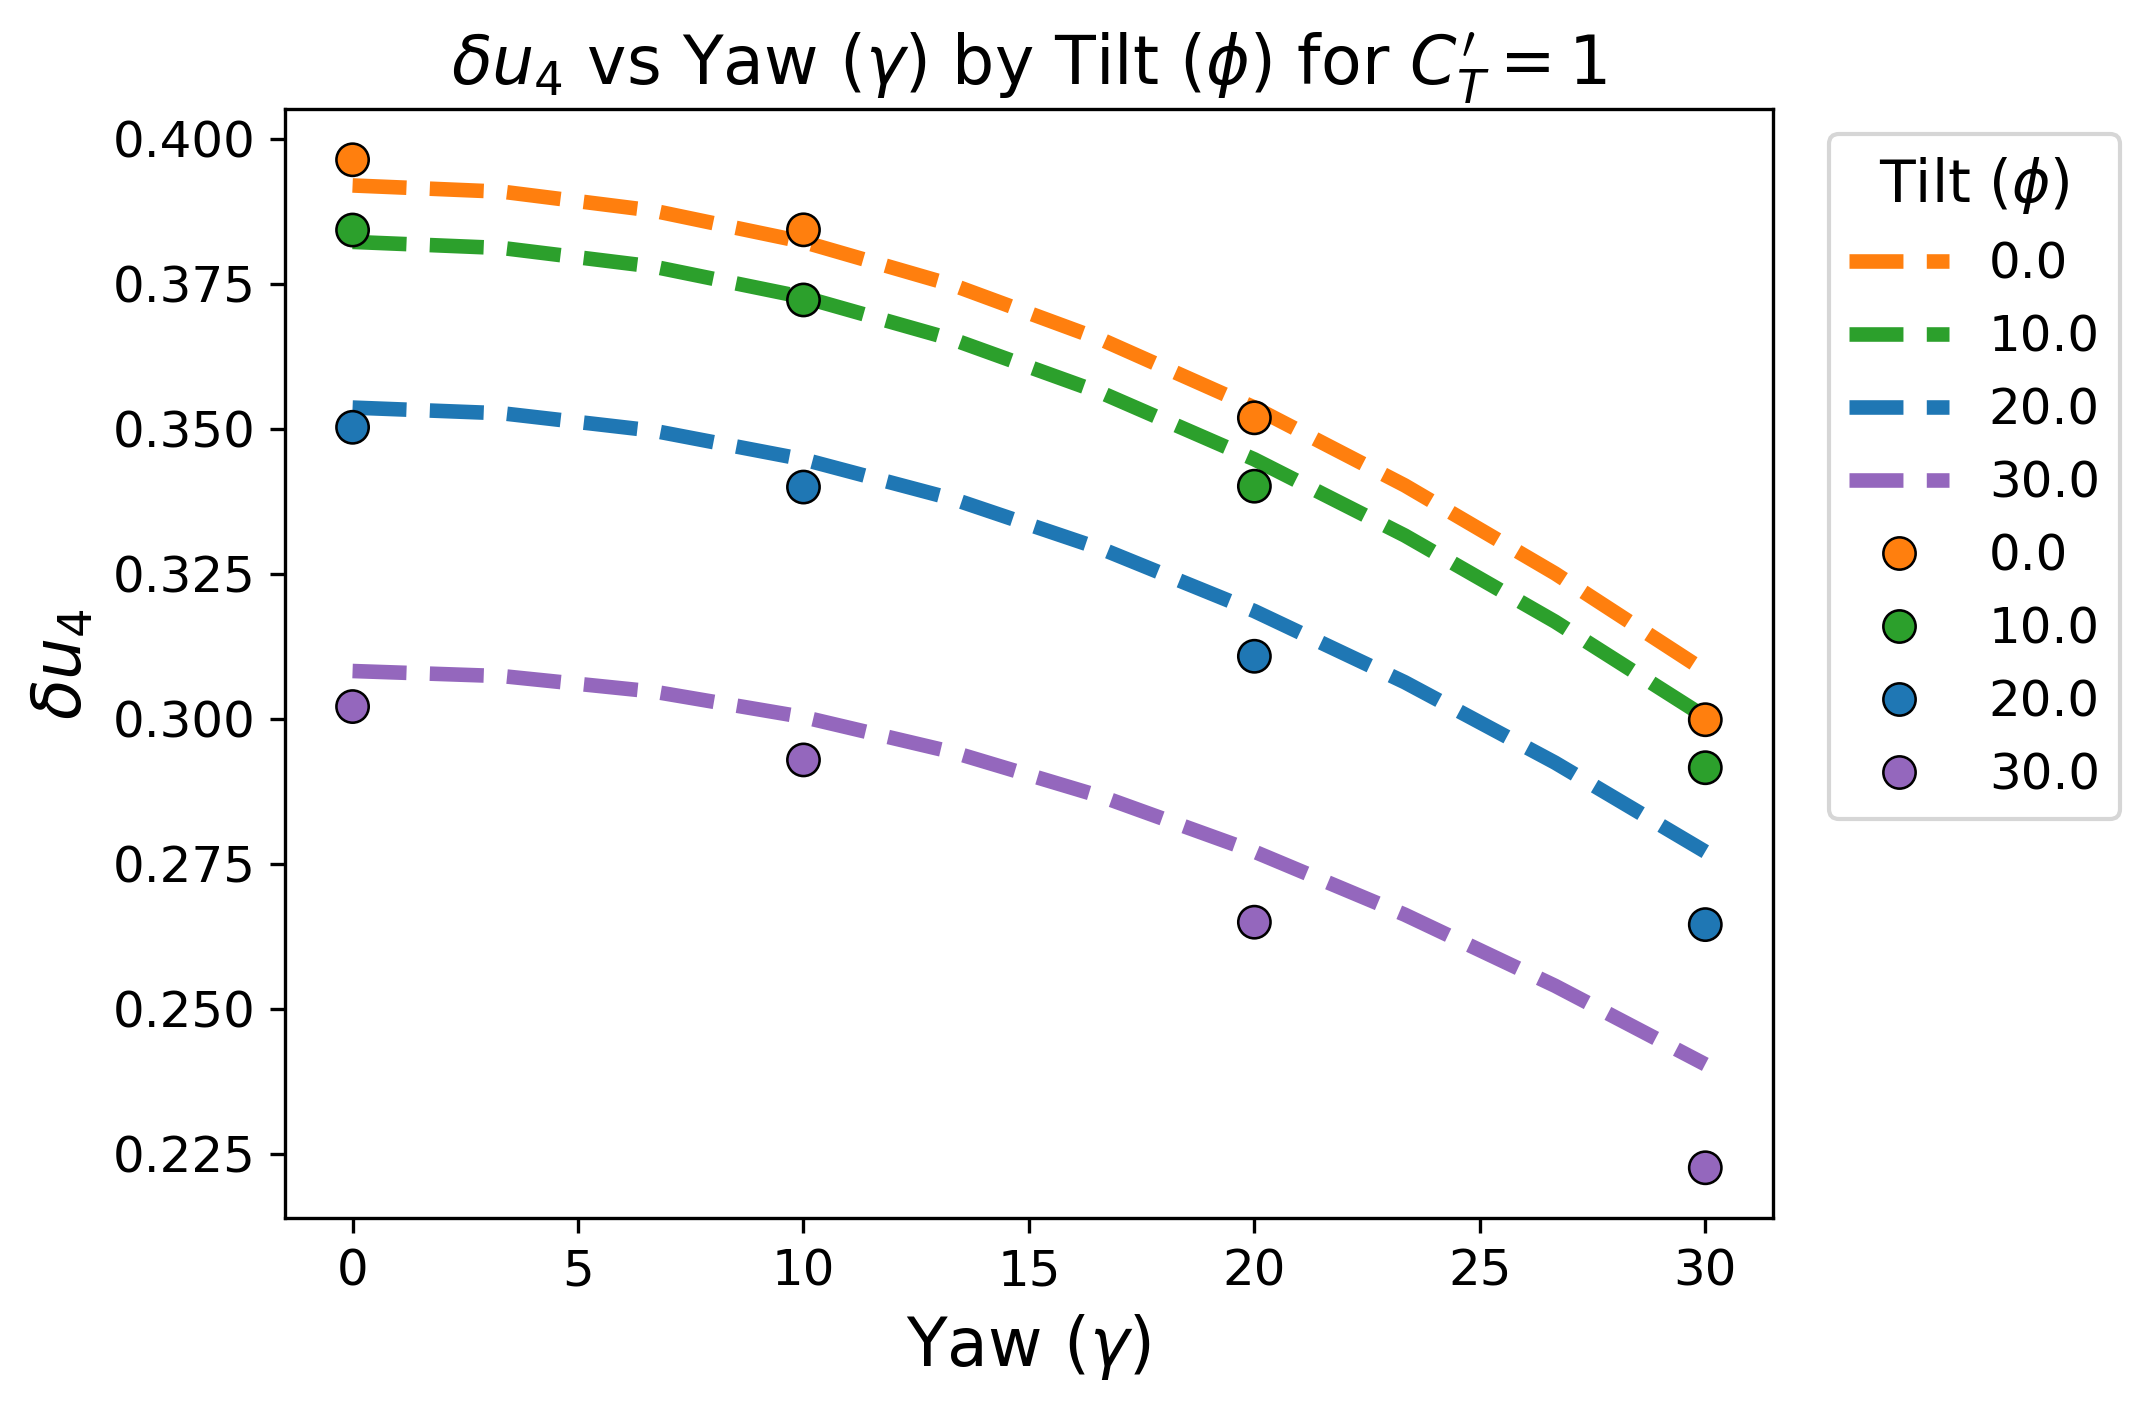

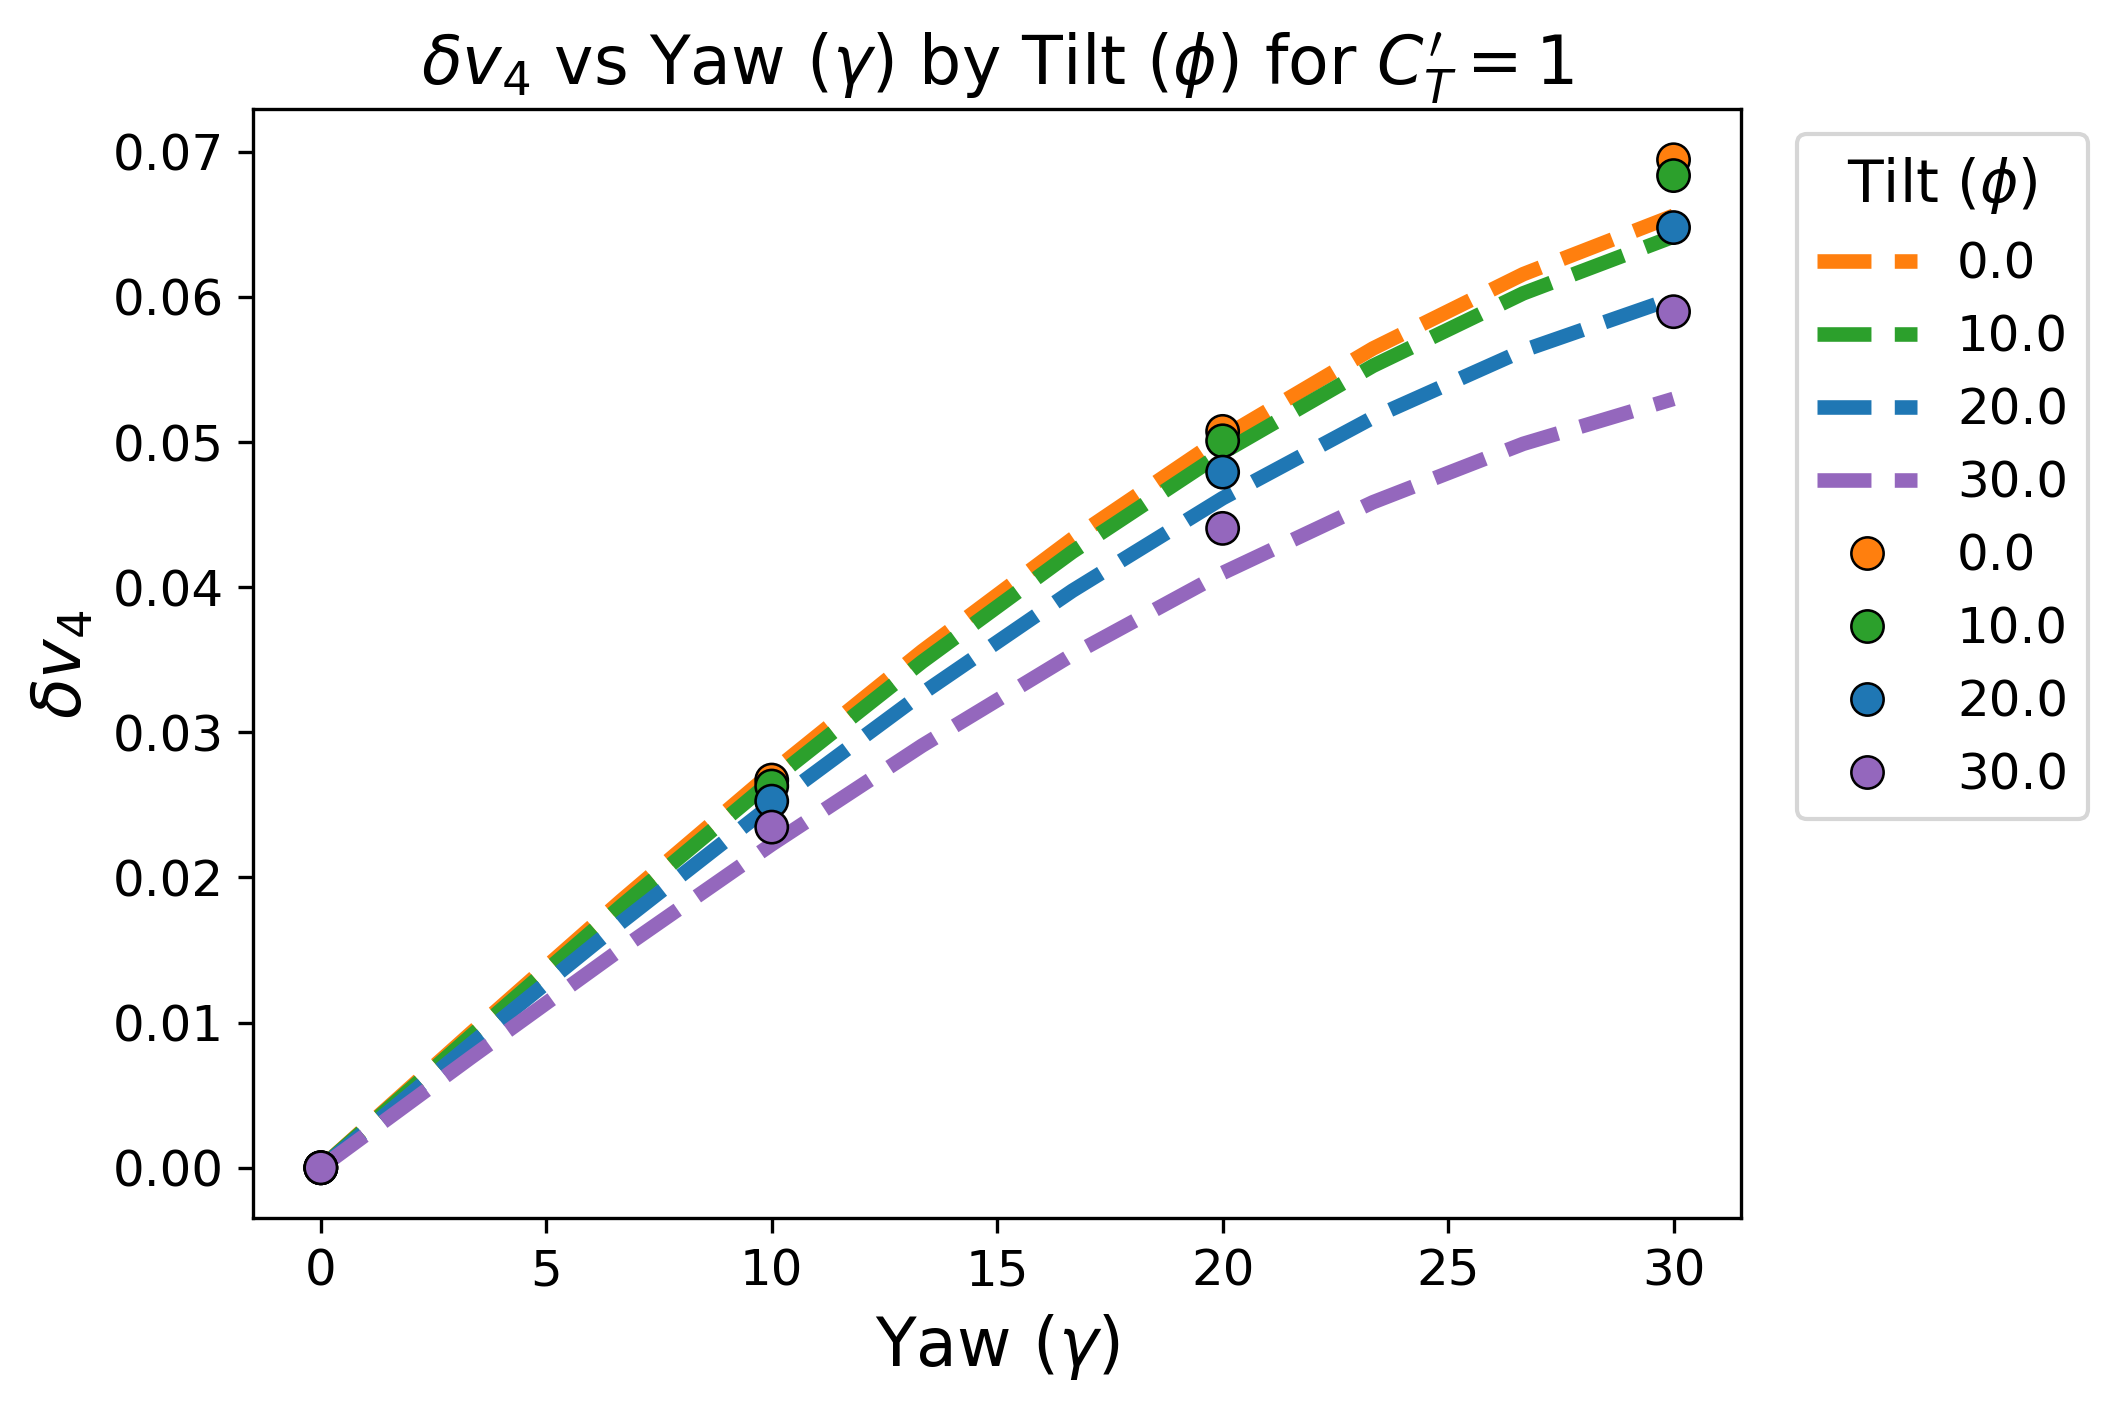

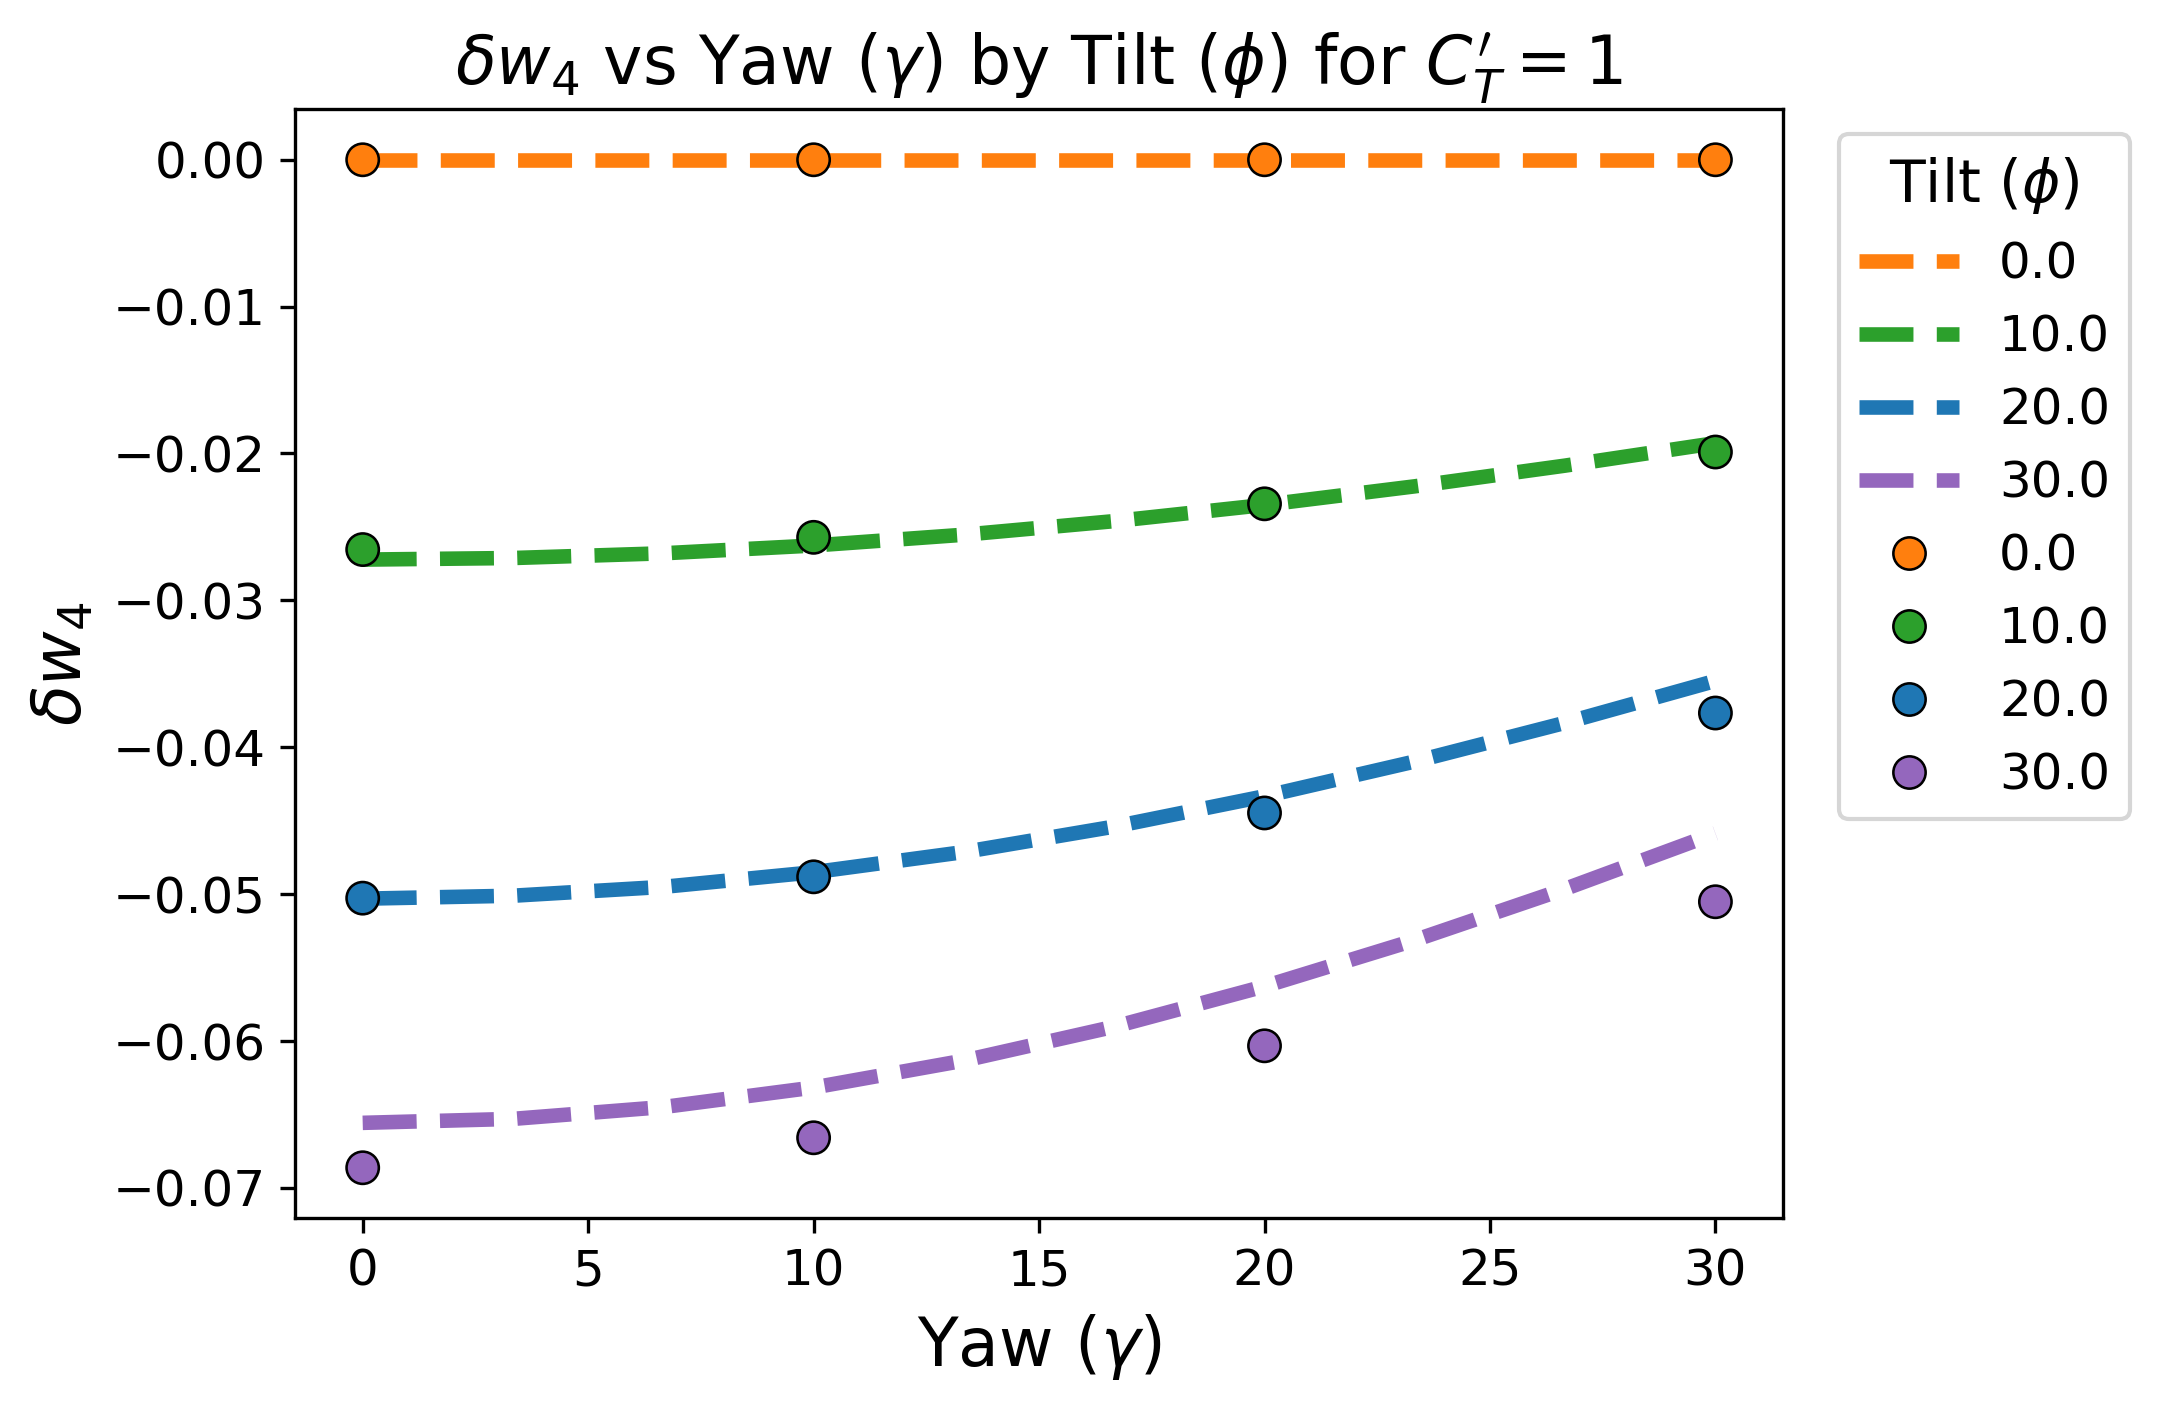

In [81]:
(vels_fig0, vels_ax0), (vels_fig1, vels_ax1), (vels_fig2, vels_ax2) = plot_vels(limited_tilt_umm_df, limited_yaw_umm_df)

sns.scatterplot(ax = vels_ax0, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "du4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5)
leg0 = vels_ax0.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg0.get_bbox_to_anchor().transformed(vels_ax0.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg0 = leg0.set_bbox_to_anchor(bb, transform = vels_ax0.transAxes)

sns.scatterplot(ax = vels_ax1, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "dv4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5)
leg1 = vels_ax1.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg1.get_bbox_to_anchor().transformed(vels_ax1.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg1 = leg1.set_bbox_to_anchor(bb, transform = vels_ax1.transAxes)
 
sns.scatterplot(ax = vels_ax2, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "dw4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5)
leg2 = vels_ax2.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg2.get_bbox_to_anchor().transformed(vels_ax2.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg2 = leg2.set_bbox_to_anchor(bb, transform = vels_ax2.transAxes)

## Quantify Error

In [82]:
compare_umm_df = limited_yaw_tilt_umm_df[limited_yaw_tilt_umm_df["Ctprime"] == 1]
compare_les_df = les_df[les_df["Ctprime"] == 1]

cp_err_vals = []
du4_err_vals = []
dv4_err_vals = []
dw4_err_vals = []
for row_idx, row in compare_umm_df.iterrows():
    y, t = row["yaw"], row["tilt"]
    les_row = compare_les_df[(compare_les_df["tilt"] == t) & (compare_les_df["yaw"] == y)]
    cp_err_vals.append(((row["Cp"] - les_row["Cp"]) / les_row["Cp"]).item() * 100)
    du4_err_vals.append(((row["du4"] - les_row["du4"]) / les_row["du4"]).item() * 100)
    if y == 0:
        dv4_err_vals.append(np.nan)
    else:
        dv4_err_vals.append(((row["dv4"] - les_row["dv4"]) / les_row["dv4"]).item() * 100)
    if t == 0:
        dw4_err_vals.append(np.nan)
    else:
        dw4_err_vals.append(((row["dw4"] - les_row["dw4"]) / les_row["dw4"]).item() * 100 )

compare_umm_df["cp_err"] = cp_err_vals
compare_umm_df["du4_err"] = du4_err_vals
compare_umm_df["dv4_err"] = dv4_err_vals
compare_umm_df["dw4_err"] = dw4_err_vals

/tmp/ipykernel_2548020/3888804241.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_umm_df["cp_err"] = cp_err_vals
/tmp/ipykernel_2548020/3888804241.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_umm_df["du4_err"] = du4_err_vals
/tmp/ipykernel_2548020/3888804241.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [83]:
def plot_error_barplot(data, err_col, err_name):
    fig, ax0 = plt.subplots(dpi = 300)
    ax0.set_title(f"{err_name} vs Yaw ($\gamma$) by Tilt ($\phi$) for $C_T' = 1$", size = 16)
    ax0.set_ylabel(f"{err_name} (%)", size = 16)
    ax0.set_xlabel('Yaw ($\\gamma$)', size = 16)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    sns.barplot(data, x="yaw", y=err_col, hue="tilt", palette = palette)
    ax0.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
    return

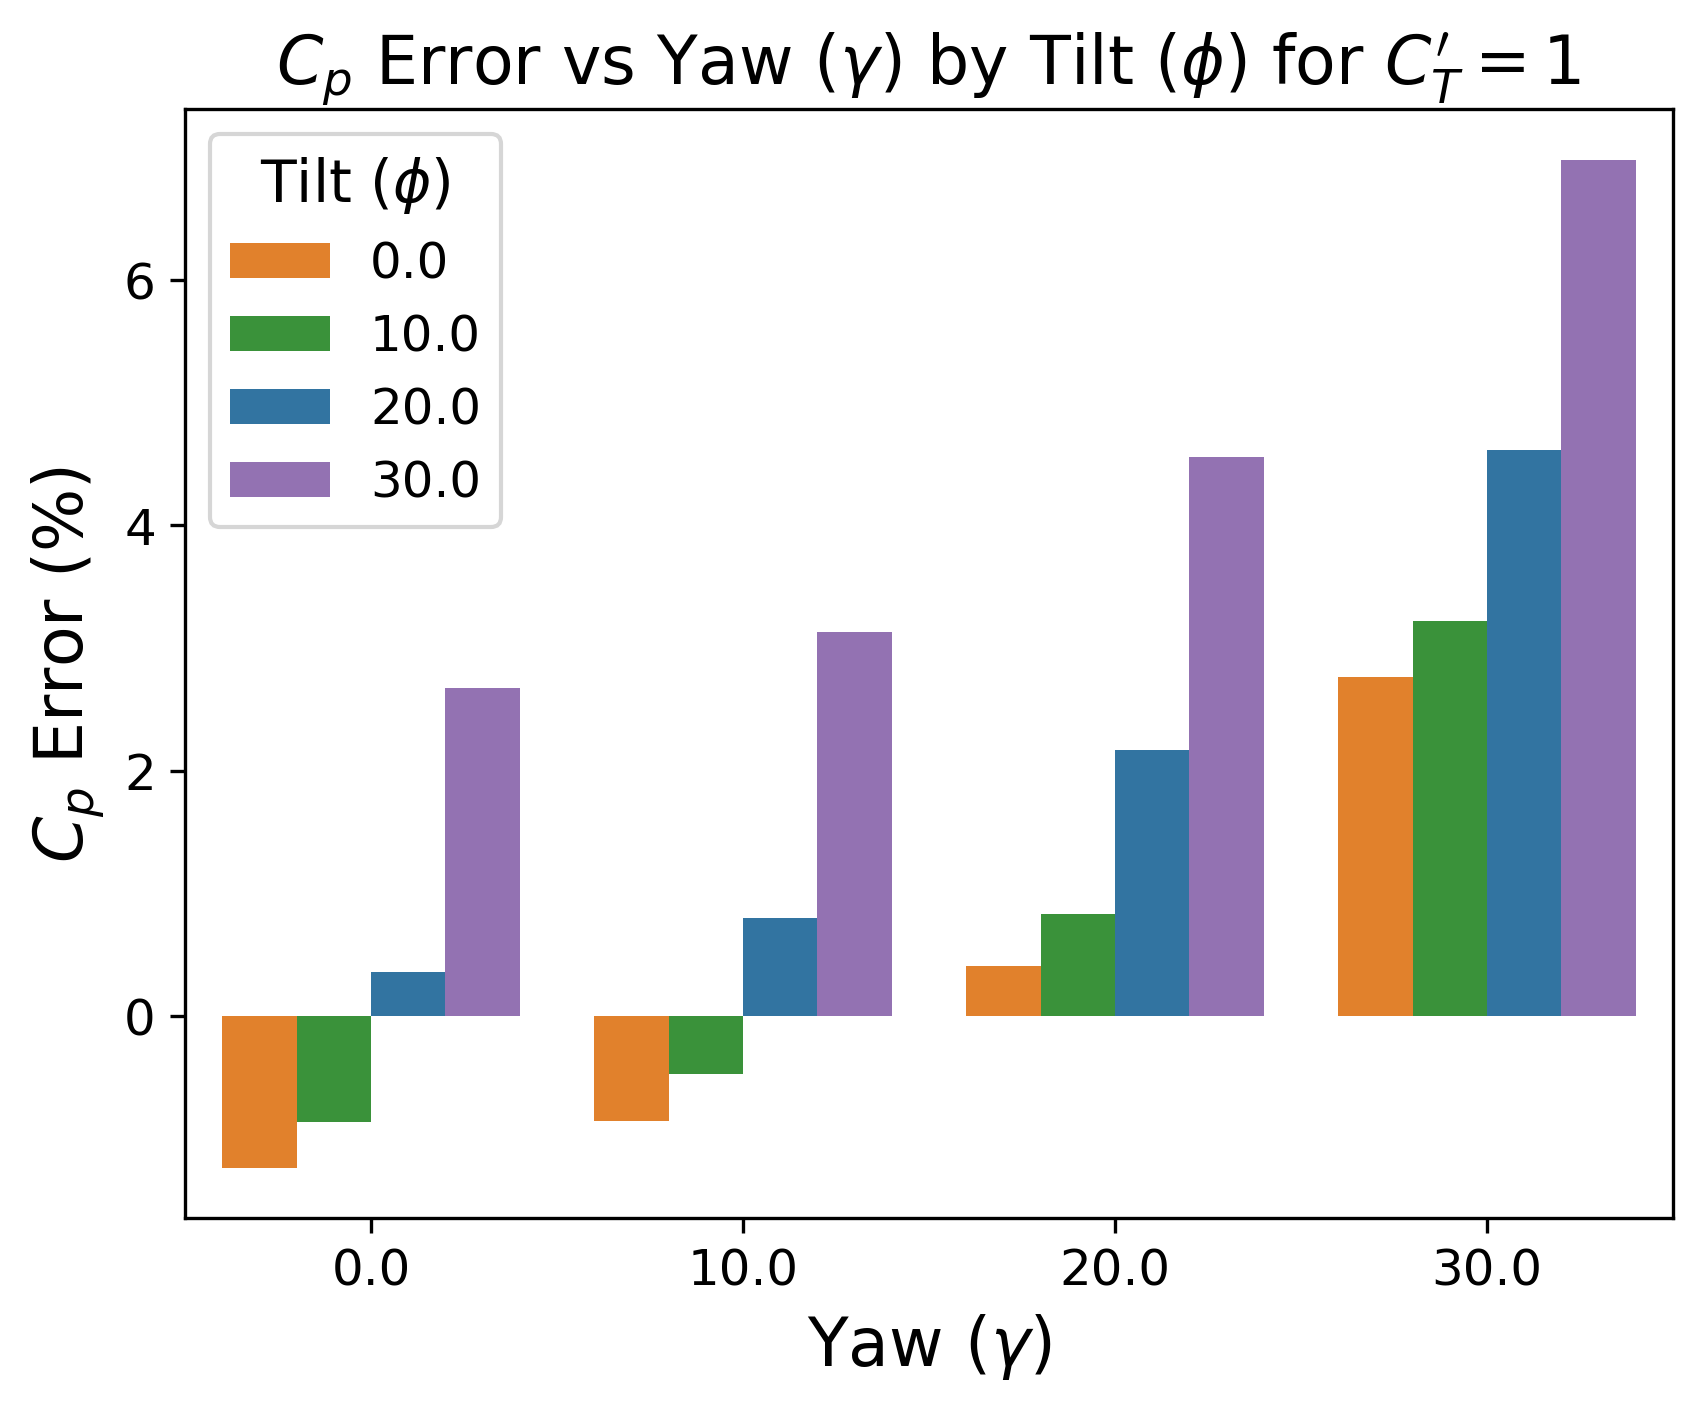

In [84]:
plot_error_barplot(compare_umm_df, "cp_err", "$C_p$ Error")

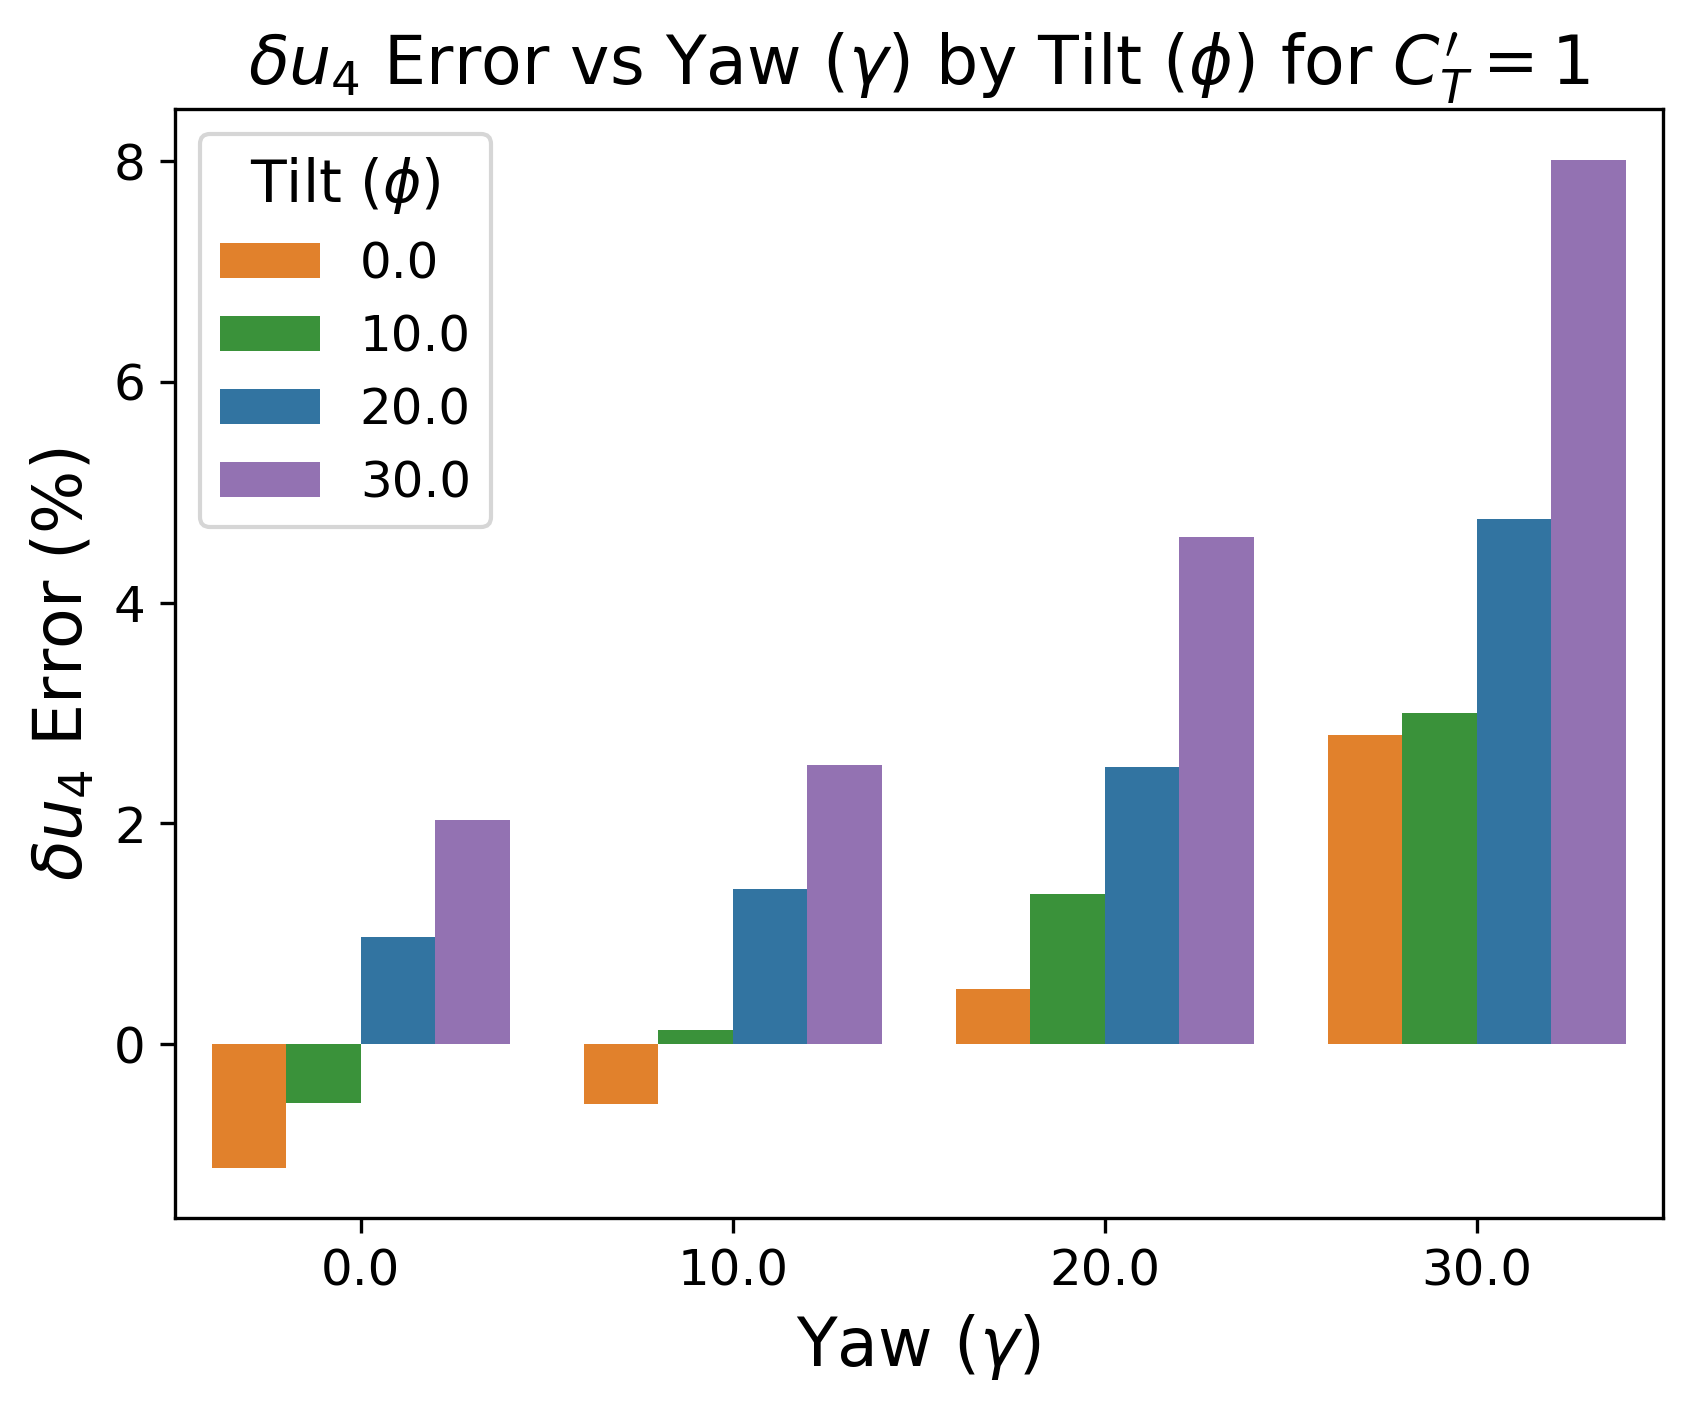

In [85]:
plot_error_barplot(compare_umm_df, "du4_err", "$\delta u_4$ Error")

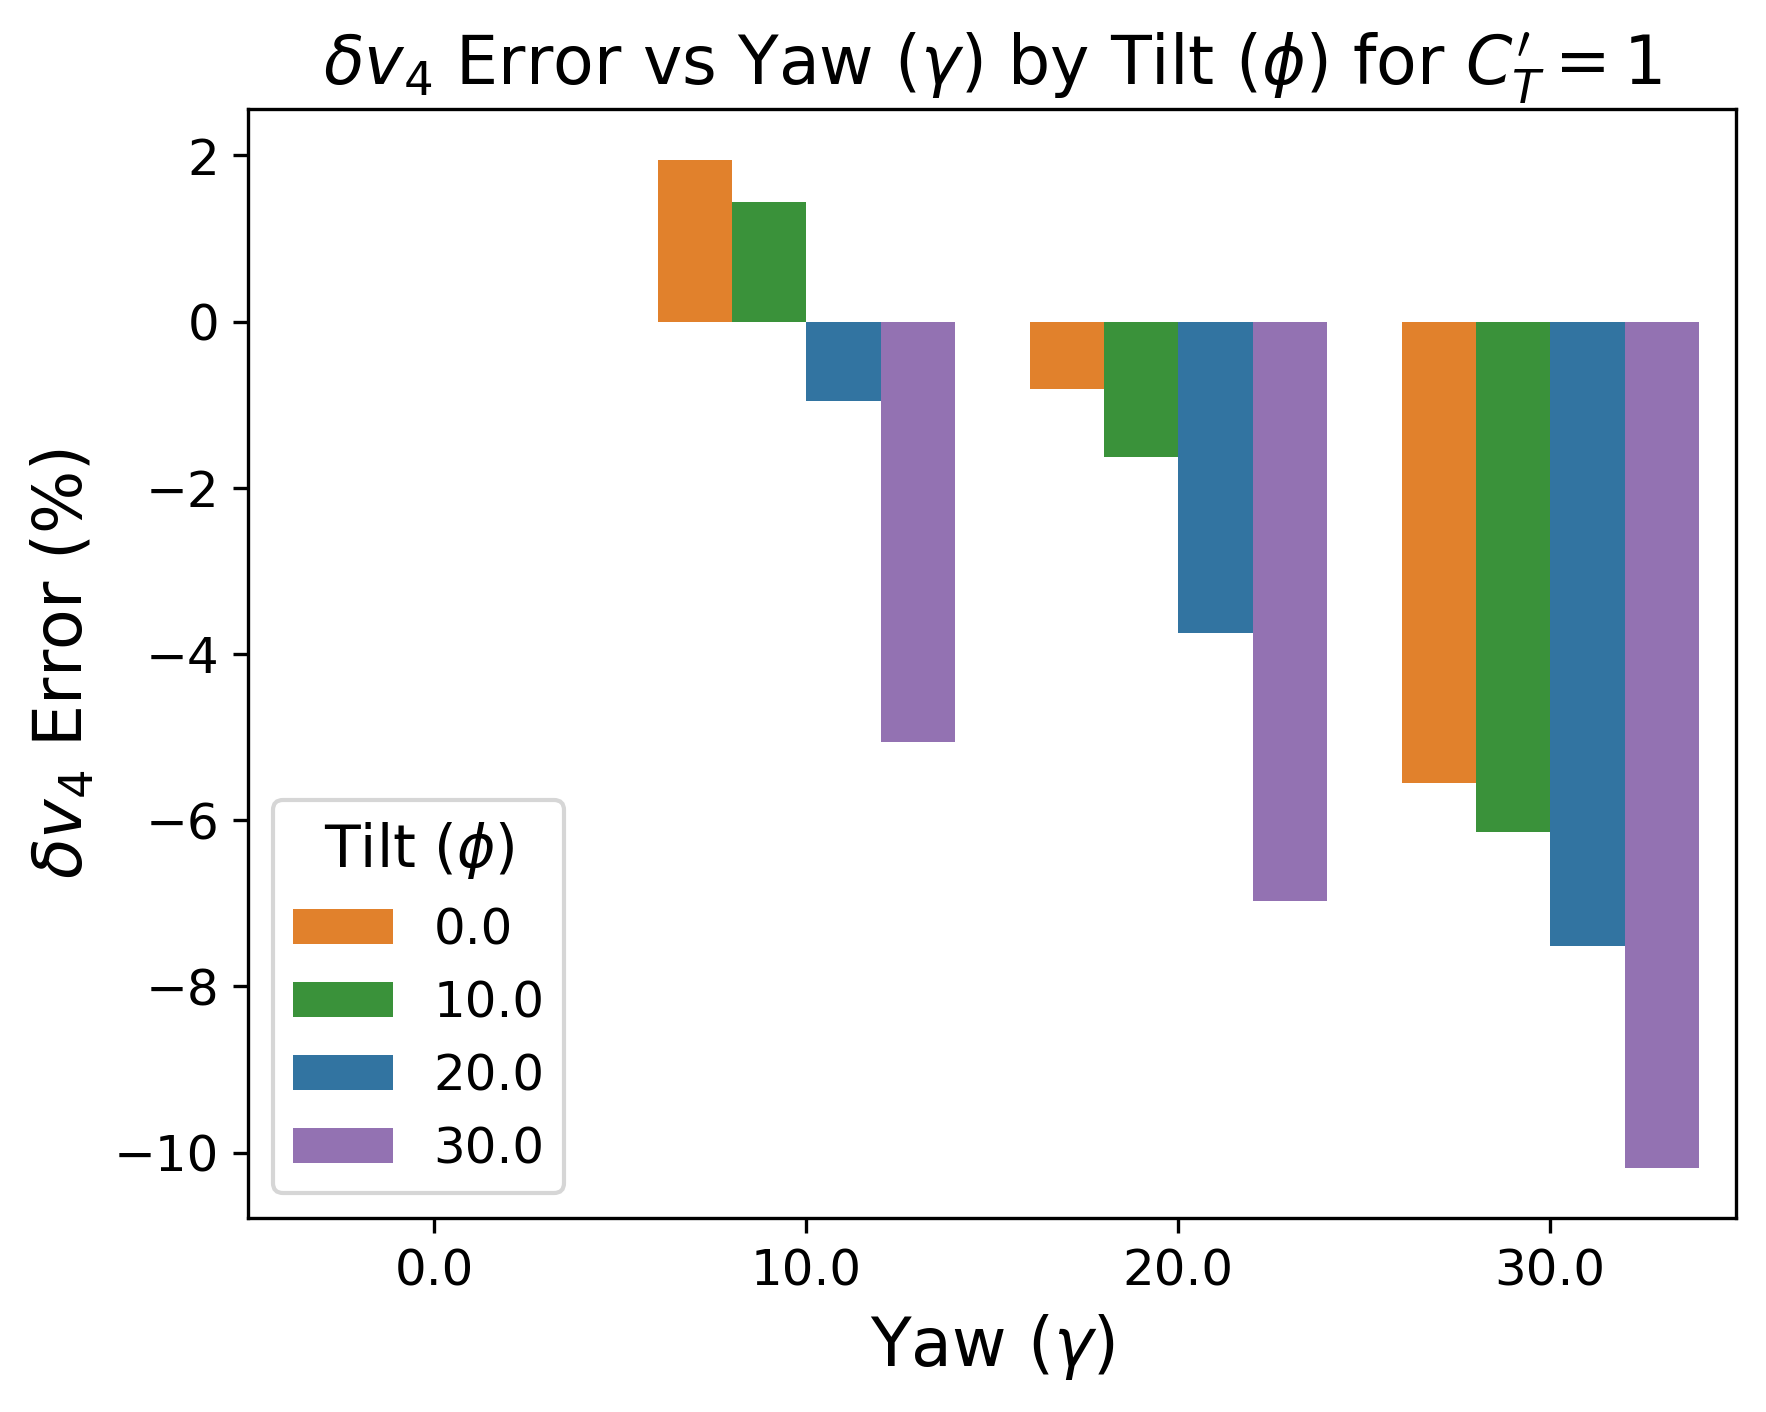

In [86]:
plot_error_barplot(compare_umm_df, "dv4_err", "$\delta v_4$ Error")

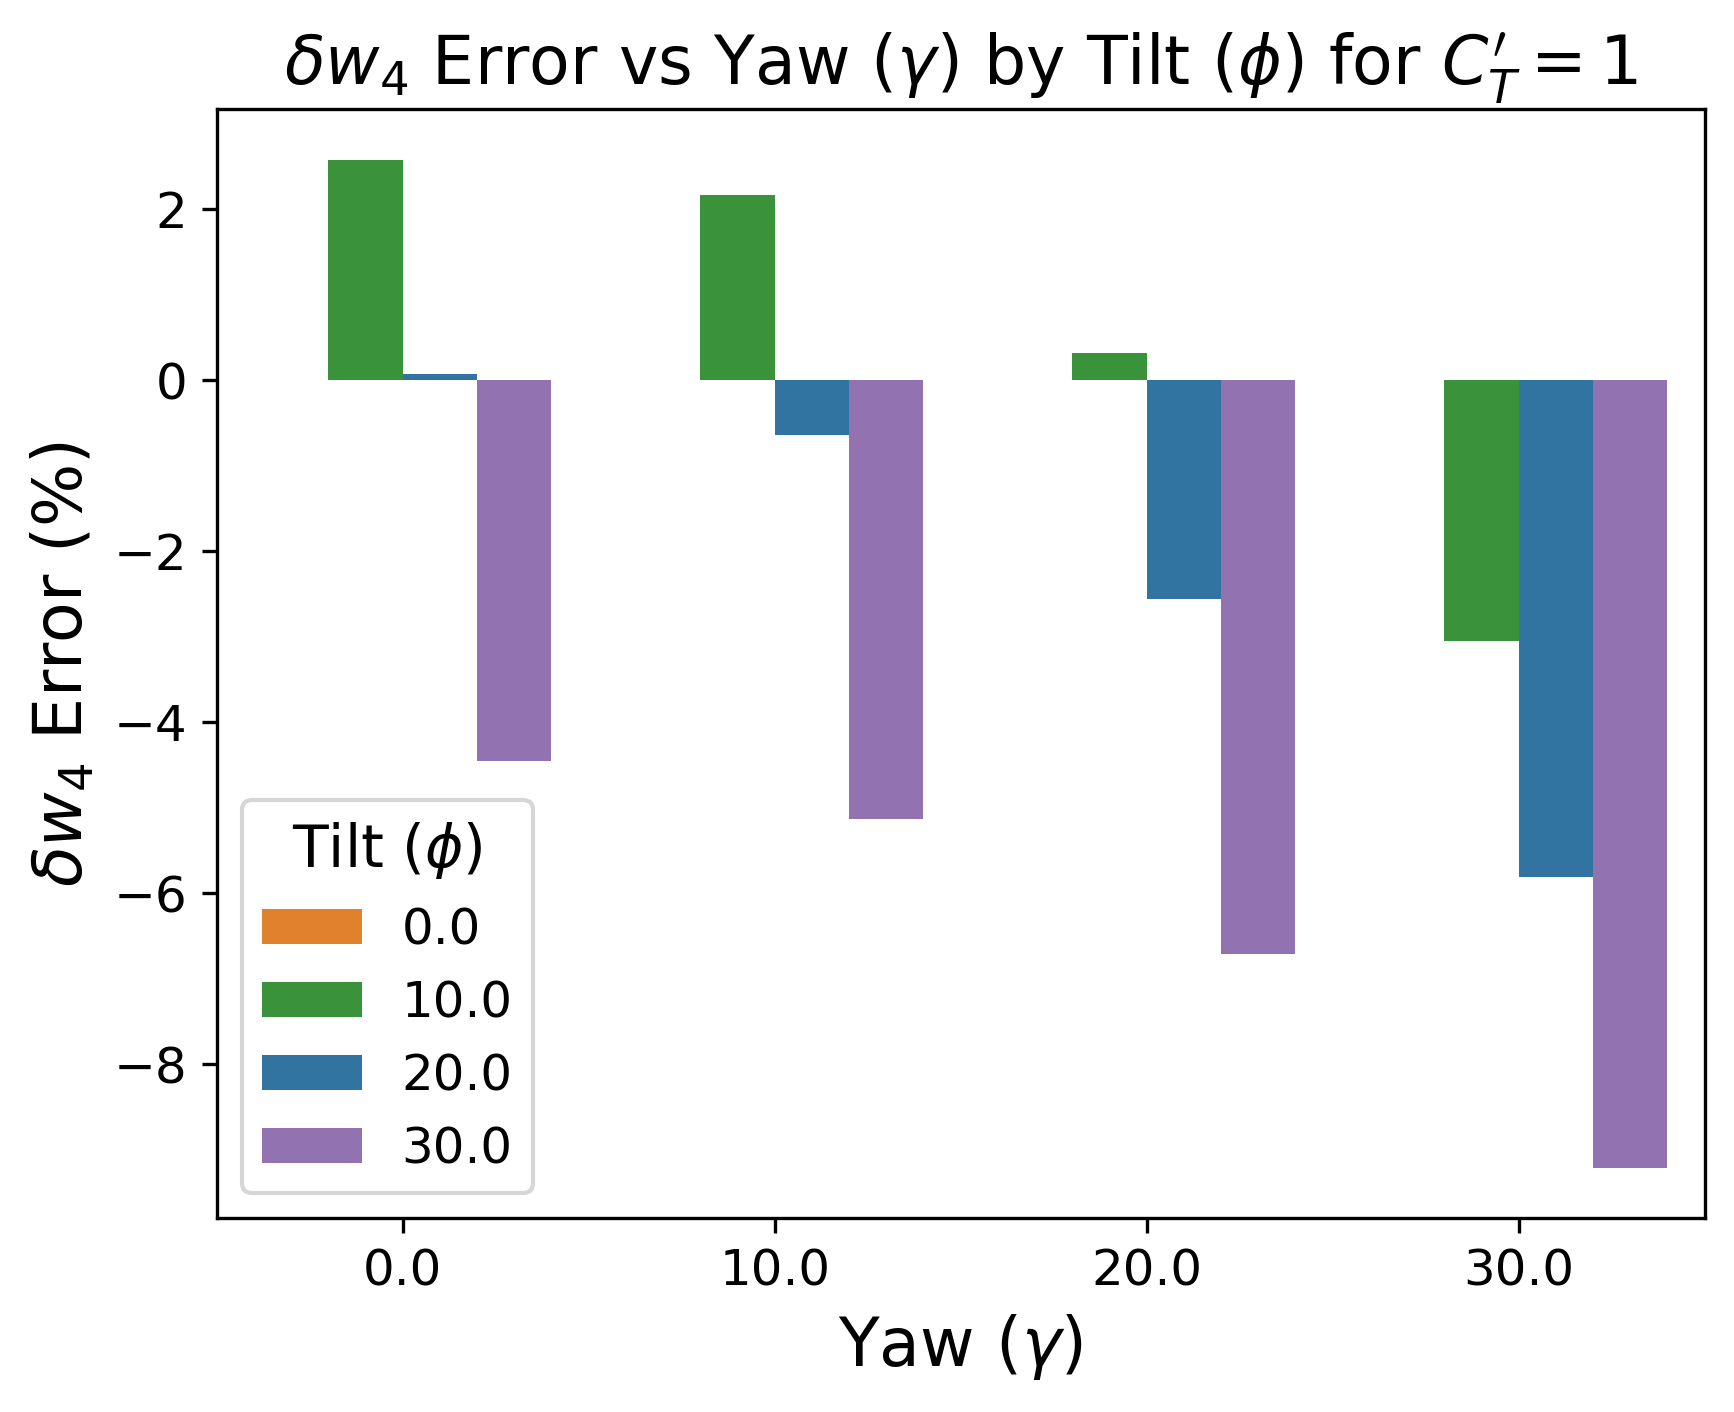

In [87]:
plot_error_barplot(compare_umm_df, "dw4_err", "$\delta w_4$ Error")

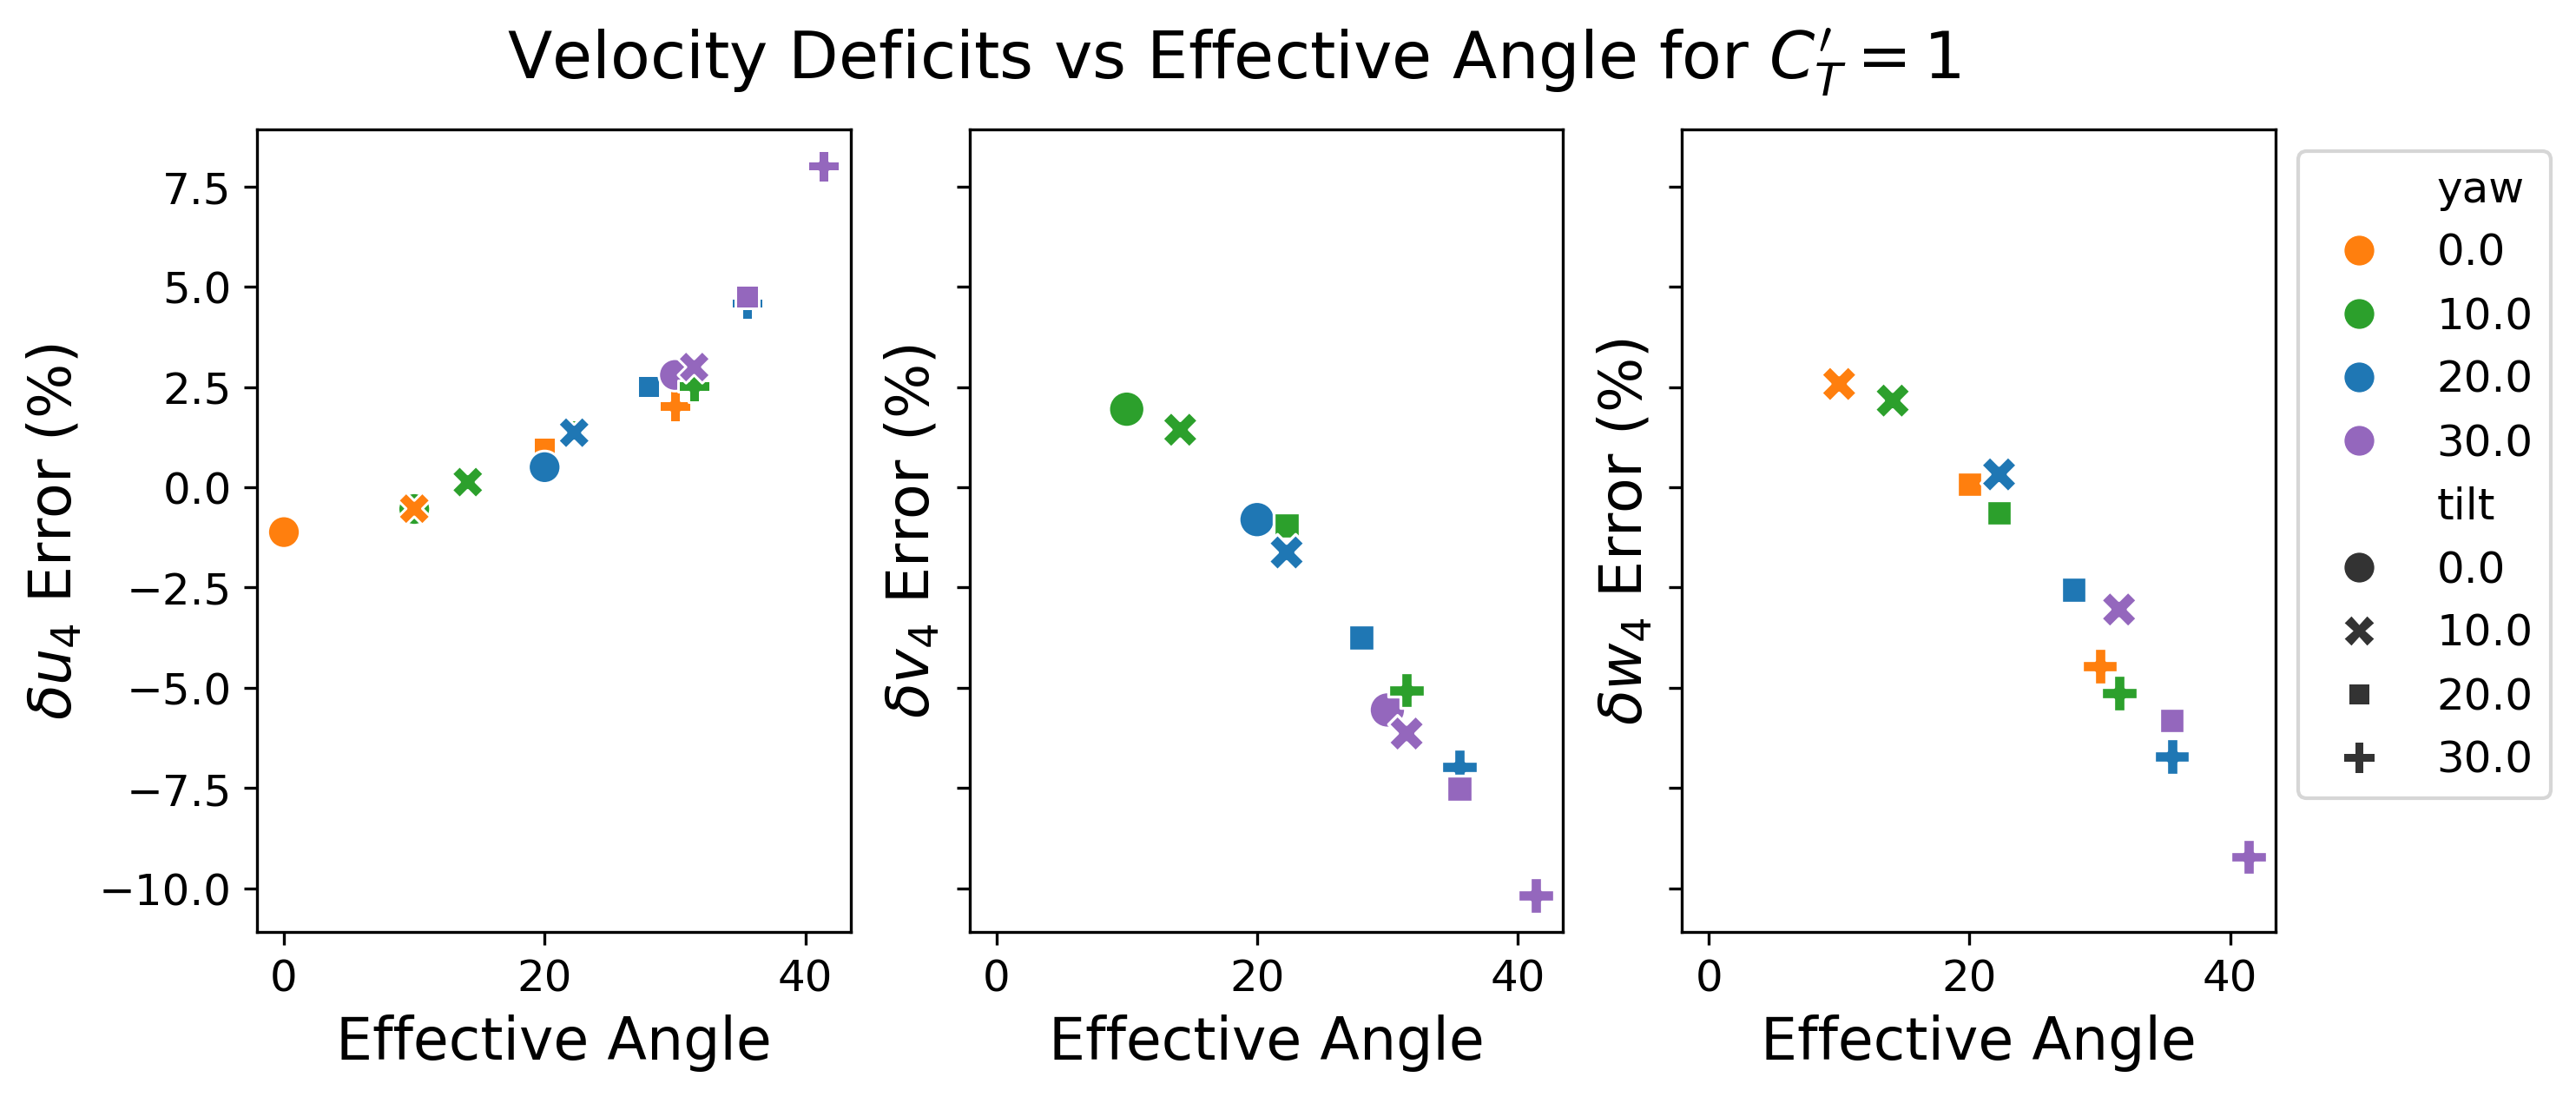

In [89]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (10, 4), dpi = 300)
fig.suptitle("Velocity Deficits vs Effective Angle for $C_T' = 1$", size = 18)

ax0.set_ylabel("$\delta u_4$ Error (%)", size = 16)
ax1.set_ylabel("$\delta v_4$ Error (%)", size = 16)
ax2.set_ylabel("$\delta w_4$ Error (%)", size = 16)

ax0.set_xlabel('Effective Angle', size = 16)
ax1.set_xlabel('Effective Angle', size = 16)
ax2.set_xlabel('Effective Angle', size = 16)

ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

sns.scatterplot(ax = ax0, data = compare_umm_df, x="angle", y="du4_err", hue="yaw", style = "tilt", palette = palette, s = 80)
sns.scatterplot(ax = ax1, data = compare_umm_df, x="angle", y="dv4_err", hue="yaw", style = "tilt", palette = palette, legend = False, s = 100)
sns.scatterplot(ax = ax2, data = compare_umm_df, x="angle", y="dw4_err", hue="yaw", style = "tilt", palette = palette, legend = False, s = 100)
leg = ax0.legend(title_fontsize=14, fontsize=12)
bb = leg.get_bbox_to_anchor().transformed(ax0.transAxes.inverted())
xOffset = 2.9
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax0.transAxes)